# Exploratory Data Analysis (EDA)
## Анализ рынка коммерческой недвижимости

В данном ноутбуке проводится разведочный анализ данных (EDA) объединенного датасета коммерческой недвижимости, собранного из различных источников:
- Веб-скрапинг: Crexi, LoopNet
- API: Census Bureau (демографические данные), Google Maps (транспортные данные)

**Бизнес-задача:** Прогнозирование стоимости аренды и выявление перспективных локаций для ритейлеров

**Целевая переменная:** `price_per_sqft` (цена за квадратный фут)


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from pathlib import Path

warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Настройка отображения pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Библиотеки импортированы успешно")


Библиотеки импортированы успешно


In [3]:
# Загрузка данных
data_path = Path('../data/processed/combined_dataset.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"Данные загружены успешно. Размер датасета: {df.shape}")
    print(f"Количество записей: {len(df)}")
    print(f"Количество признаков: {len(df.columns)}")
else:
    print(f"Файл {data_path} не найден. Пожалуйста, сначала запустите скрипты сбора данных.")
    df = pd.DataFrame()


Данные загружены успешно. Размер датасета: (9967, 65)
Количество записей: 9967
Количество признаков: 65


In [4]:
# Удаление столбцов, полностью заполненных пропусками
if not df.empty:
    empty_cols = df.columns[df.isna().all()]
    if len(empty_cols) > 0:
        print("Удалены столбцы без данных:", list(empty_cols))
        df = df.drop(columns=empty_cols)
    else:
        print("Столбцов, полностью заполненных пропусками, не обнаружено")


Удалены столбцы без данных: ['latitude', 'longitude', 'nearby_malls_count', 'nearby_transit_stations_count', 'min_distance_to_key_location_km', 'min_duration_to_key_location_min']


## 1. Первичный обзор данных

### Выводы:
- **Размер датасета после удаления пустых столбцов**: 9 967 записей × 59 признаков (6 пустых колонок из Google Maps исключены).
- **Типы данных**: {'float64': 43, 'object': 10, 'int64': 6} — числовая часть значительно расширена за счёт `census_*` признаков.
- **Основные признаки**: price, square_feet, price_per_sqft, price_per_sqft_log, демографические агрегаты `census_*`, description, city, state.
- **Источники данных**: Crexi, LoopNet, Census Bureau (агрегировано по штату), Google Maps (только транспортные признаки с заполнением).



In [5]:
# Первый взгляд на данные
if not df.empty:
    print("Первые 5 строк:")
    display(df.head())

    print("\nИнформация о датасете:")
    print(df.info())

    print("\nОсновные статистики:")
    display(df.describe())

    print("\nСписок колонок:")
    print(df.columns.tolist())


Первые 5 строк:


,source,url,property_id,title,description,price,square_feet,price_per_sqft,property_type,city,state,address,year_built,parking_spaces,listing_date,census_population_mean,census_population_median,census_median_household_income_mean,census_median_household_income_median,census_in_labor_force_mean,census_in_labor_force_median,census_civilian_labor_force_mean,census_civilian_labor_force_median,census_employed_mean,census_employed_median,census_unemployed_mean,census_unemployed_median,census_employment_rate_mean,census_employment_rate_median,census_total_housing_units_mean,census_total_housing_units_median,census_total_occupied_mean,census_total_occupied_median,census_occupied_mean,census_occupied_median,census_vacant_mean,census_vacant_median,census_vacancy_rate_mean,census_vacancy_rate_median,census_total_population_25plus_mean,census_total_population_25plus_median,census_bachelors_degree_mean,census_bachelors_degree_median,census_masters_degree_mean,census_masters_degree_median,census_professional_degree_mean,census_professional_degree_median,census_doctorate_degree_mean,census_doctorate_degree_median,census_bachelors_degree_rate_mean,census_bachelors_degree_rate_median,census_masters_degree_rate_mean,census_masters_degree_rate_median,census_professional_degree_rate_mean,census_professional_degree_rate_median,census_doctorate_degree_rate_mean,census_doctorate_degree_rate_median,description_length,description_word_count
0,Crexi,https://www.crexi.com/property/872246,CREX_207473,"Retail Space in New York, NY",Prime commercial retail space located in a hig...,1932427,10344,186.816222,Retail,New York,NY,"4606 Broadway, New York, NY",2019,11,2025-01-14,12422.932715,1880.0,81586.848460,67625.0,6396.583140,960.0,6382.418407,960.0,5998.877030,914.0,383.541377,40.0,94.644105,95.699298,5214.606342,883.0,5214.606342,883.0,4689.392111,746.0,525.214230,89.0,15.094150,9.372843,8628.911060,1288.0,1845.569219,228.0,1027.239753,139.0,272.211910,20.0,137.096674,11.0,18.719659,17.242788,11.611289,10.428114,2.952338,1.288457,1.756140,0.694542,203,26
1,Crexi,https://www.crexi.com/property/629903,CREX_731262,"Retail Space in Houston, TX",Prime commercial retail space located in a hig...,1894068,16447,115.161914,Retail,Houston,TX,"588 Main St, Houston, TX",1953,71,2025-08-03,12082.072581,1231.0,61370.686113,52941.0,6111.810215,540.0,6065.532258,539.5,5741.850538,508.5,323.681720,24.0,93.881290,95.735608,4723.070430,533.5,4723.070430,533.5,4245.334946,424.5,477.735484,81.0,18.748350,14.285714,7739.604301,802.0,1568.654301,74.0,631.056989,23.0,144.005376,0.0,97.681720,0.0,13.322195,10.632911,4.620961,3.105590,0.890983,0.000000,0.628446,0.000000,203,26
2,Crexi,https://www.crexi.com/property/895667,CREX_944962,"Mixed Use Space in Phoenix, AZ",Versatile mixed-use property with retail front...,2393632,1625,1473.004308,Mixed Use,Phoenix,AZ,"3711 Market St, Phoenix, AZ",1970,89,2025-04-10,14316.978587,813.0,50434.451351,45606.5,6916.394004,277.0,6872.059957,277.0,6480.269807,258.0,391.790150,23.0,90.605637,94.070554,6042.920771,405.0,6042.920771,405.0,5291.837259,302.0,751.083512,95.0,26.149956,19.507135,9652.451820,548.0,1859.867238,39.0,817.747323,18.0,187.599572,0.0,133.972163,0.0,11.146234,8.446381,4.761522,2.857877,1.020953,0.000000,0.547645,0.000000,172,23
3,Crexi,https://www.crexi.com/property/197251,CREX_498382,"Warehouse Space in Chicago, IL","Industrial warehouse with loading docks, 28-fo...",2883559,7898,365.099899,Warehouse,Chicago,IL,"2647 Broadway, Chicago, IL",1962,45,2025-05-20,7674.071623,944.0,63215.060258,56466.0,4023.989768,464.0,4012.345839,464.0,3765.156889,431.0,247.188950,23.0,94.167931,95.189003,3233.495225,434.5,3233.495225,434.5,2942.907913,372.5,290.587312,46.0,11.843442,9.503373,5201.200546,646.0,1145.743520,73.0,548.982265,23.0,128.721692,2.0,74.493861,0.0,13.527046,11.353909,5.495557,3.930317,1.014423,0.305822,0.613847,0.000000,177,23
4,Crexi,https://www.crexi.com/property/496922,CREX_182627,"Warehouse Space in Phoenix, AZ","Indu


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9967 entries, 0 to 9966
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   source                                  9967 non-null   object 
 1   url                                     9967 non-null   object 
 2   property_id                             9967 non-null   object 
 3   title                                   9967 non-null   object 
 4   description                             9967 non-null   object 
 5   price                                   9967 non-null   int64  
 6   square_feet                             9967 non-null   int64  
 7   price_per_sqft                          9967 non-null   float64
 8   property_type                           9967 non-null   object 
 9   city                                    9967 non-null   object 
 10  state                               

,price,square_feet,price_per_sqft,year_built,parking_spaces,census_population_mean,census_population_median,census_median_household_income_mean,census_median_household_income_median,census_in_labor_force_mean,census_in_labor_force_median,census_civilian_labor_force_mean,census_civilian_labor_force_median,census_employed_mean,census_employed_median,census_unemployed_mean,census_unemployed_median,census_employment_rate_mean,census_employment_rate_median,census_total_housing_units_mean,census_total_housing_units_median,census_total_occupied_mean,census_total_occupied_median,census_occupied_mean,census_occupied_median,census_vacant_mean,census_vacant_median,census_vacancy_rate_mean,census_vacancy_rate_median,census_total_population_25plus_mean,census_total_population_25plus_median,census_bachelors_degree_mean,census_bachelors_degree_median,census_masters_degree_mean,census_masters_degree_median,census_professional_degree_mean,census_professional_degree_median,census_doctorate_degree_mean,census_doctorate_degree_median,census_bachelors_degree_rate_mean,census_bachelors_degree_rate_median,census_masters_degree_rate_mean,census_masters_degree_rate_median,census_professional_degree_rate_mean,census_professional_degree_rate_median,census_doctorate_degree_rate_mean,census_doctorate_degree_rate_median,description_length,description_word_count
count,9.967000e+03,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000,9967.000000
mean,2.524632e+06,25627.386776,193.558210,1986.269389,59.976422,13936.458153,1554.877195,67347.936758,58709.100983,7062.289521,706.798134,7023.728296,704.300893,6608.793482,658.096318,414.934814,38.363098,93.061017,95.001079,5508.611711,699.576904,5508.611711,699.576904,4977.896628,574.730611,530.715084,88.246112,17.779577,12.077616,9380.448689,1055.360088,1968.306105,137.474165,887.733138,59.460018,225.150442,9.173472,141.879382,4.184007,14.792076,12.569967,6.752812,5.027401,1.605293,0.492772,0.973798,0.206934,182.836962,24.010535
std,1.431137e+06,14113.949327,324.614807,20.975999,35.087230,5158.079644,769.480368,11813.999161,9315.282434,2615.090561,367.752547,2594.096278,363.990467,2428.880015,337.104369,166.428316,22.731294,1.521633,0.697026,1699.740277,320.525876,1699.740277,320.525876,1590.430692,273.294449,152.471569,27.308311,4.752048,4.271567,3511.985407,533.454278,777.722165,94.421017,313.480066,48.853467,98.560525,10.545787,66.971786,5.150168,2.764364,3.177752,2.603306,2.779316,0.814887,0.509019,0.482747,0.277189,10.774419,1.671553
min,6.007900e+04,1205.000000,1.406350,1950.000000,0.000000,7674.071623,813.000000,50434.451351,45606.500000,4023.989768,277.000000,4012.345839,277.000000,3765.156889,258.000000,247.188950,23.000000,90.605637,94.070554,3233.495225,405.000000,3233.495225,405.000000,2942.907913,302.000000,290.587312,46.000000,11.843442,7.824223,5201.200546,548.000000,1145.743520,39.000000,548.982265,18.000000,128.721692,0.000000,74.493861,0.000000,11.146234,8.446381,4.620961,2.857877,0.890983,0.000000,0.547645,0.000000,172.000000,22.000000
25%,1.276607e+06,13435.500000,50.388075,1968.000000,29.000000,12082.072581,944.000000,61370.686113,52941.000000,6111.810215,464.000000,6065.532258,464.000000,5741.850538,431.000000,323.681720,23.000000,91.947409,94.285714,4723.070430,434.500000,4723.070430,434.500000,4245.334946,372.500000,477.735484,81.000000,15.094150,9.372843,7739.604301,646.000000,1568.654301,73.000000,631.056989,23.000000,144.005376,0.000000,97.681720,0.000000,13.322195,10.632911,4.761522,3.


Список колонок:
['source', 'url', 'property_id', 'title', 'description', 'price', 'square_feet', 'price_per_sqft', 'property_type', 'city', 'state', 'address', 'year_built', 'parking_spaces', 'listing_date', 'census_population_mean', 'census_population_median', 'census_median_household_income_mean', 'census_median_household_income_median', 'census_in_labor_force_mean', 'census_in_labor_force_median', 'census_civilian_labor_force_mean', 'census_civilian_labor_force_median', 'census_employed_mean', 'census_employed_median', 'census_unemployed_mean', 'census_unemployed_median', 'census_employment_rate_mean', 'census_employment_rate_median', 'census_total_housing_units_mean', 'census_total_housing_units_median', 'census_total_occupied_mean', 'census_total_occupied_median', 'census_occupied_mean', 'census_occupied_median', 'census_vacant_mean', 'census_vacant_median', 'census_vacancy_rate_mean', 'census_vacancy_rate_median', 'census_total_population_25plus_mean', 'census_total_population_2

## 2. Анализ пропущенных значений


In [7]:
# Анализ пропущенных значений
if not df.empty:
    # Подсчет пропущенных значений
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum().values,
        'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
    })
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    print("Пропущенные значения:")
    display(missing_data)

    # Визуализация пропущенных значений
    if len(missing_data) > 0:
        plt.figure(figsize=(12, 8))
        plt.barh(missing_data['Column'], missing_data['Missing_Percentage'])
        plt.xlabel('Процент пропущенных значений (%)')
        plt.ylabel('Признак')
        plt.title('Распределение пропущенных значений по признакам')
        plt.tight_layout()
        plt.show()

        # Общая разреженность датасета
        total_missing = df.isnull().sum().sum()
        total_cells = df.shape[0] * df.shape[1]
        sparsity = (total_missing / total_cells) * 100
        print(f"\nОбщая разреженность датасета: {sparsity:.2f}%")
        print(f"Всего пропущенных значений: {total_missing} из {total_cells}")


Пропущенные значения:


,Column,Missing_Count,Missing_Percentage


### Гипотезы о пропущенных значениях

**Если появятся пропуски в новых выгрузках:**
- В `price` это может означать, что объект не выставлен на продажу/аренду или цена скрыта.
- В `square_feet` — что площадь не указана или объект еще не построен.
- В демографических данных — что для конкретного FIPS отсутствуют данные в Census Bureau.
- В транспортных данных — что адрес не был найден в Google Maps или координаты не определены.

### Выводы по пропущенным значениям:
- **Общая разреженность датасета**: 0% (после агрегирования по FIPS и удаления полностью пустых колонок пропуски отсутствуют).
- **Ранее пустые блоки**: демография и транспорт — заполнены агрегированными показателями Census и удалением незаполненных транспортных столбцов.
- **Ключевые признаки заполнены**: price, square_feet, price_per_sqft, description и `census_*` показатели имеют полное покрытие.
- **Обработка**: удалены 6 полностью пустых колонок Google Maps, демографические метрики агрегированы по штату и приведены к почтовым аббревиатурам.


In [8]:
# Обработка пропущенных значений
if not df.empty:
    df_cleaned = df.copy()

    # Для числовых признаков - заполнение медианой (если пропусков немного)
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_cleaned[col].isnull().sum() > 0 and df_cleaned[col].isnull().sum() < len(df_cleaned) * 0.5:
            median_val = df_cleaned[col].median()
            df_cleaned[col].fillna(median_val, inplace=True)
            print(f"Заполнено пропусков в {col}: медиана = {median_val:.2f}")

    # Для текстовых признаков - заполнение пустой строкой
    text_cols = ['title', 'description', 'address']
    for col in text_cols:
        if col in df_cleaned.columns:
            df_cleaned[col].fillna('', inplace=True)
            print(f"Заполнено пропусков в {col}: пустая строка")

    # Для категориальных признаков - заполнение 'Unknown'
    categorical_cols = ['city', 'state', 'property_type', 'source']
    for col in categorical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col].fillna('Unknown', inplace=True)
            print(f"Заполнено пропусков в {col}: 'Unknown'")

    print("\nОбработка пропущенных значений завершена")
    print(f"Осталось пропущенных значений: {df_cleaned.isnull().sum().sum()}")


Заполнено пропусков в title: пустая строка
Заполнено пропусков в description: пустая строка
Заполнено пропусков в address: пустая строка
Заполнено пропусков в city: 'Unknown'
Заполнено пропусков в state: 'Unknown'
Заполнено пропусков в property_type: 'Unknown'
Заполнено пропусков в source: 'Unknown'

Обработка пропущенных значений завершена
Осталось пропущенных значений: 0


In [7]:
# Дополнительная очистка: удаляем столбцы с нулевой вариативностью
if 'df_cleaned' in locals() and not df_cleaned.empty:
    constant_cols = [col for col in df_cleaned.columns if df_cleaned[col].nunique(dropna=True) <= 1]
    if constant_cols:
        print("Удалены столбцы без вариативности:", constant_cols)
        df_cleaned = df_cleaned.drop(columns=constant_cols)
    else:
        print("Столбцов без вариативности не обнаружено")


Столбцов без вариативности не обнаружено


## 3. Анализ ошибочных значений

### Выводы:
- **Отрицательные цены**: 0 записей - данные корректны
- **Отрицательная площадь**: 0 записей - данные корректны
- **Экстремально высокие цены** (>$1000 за кв.фут): 336 записей (3.4% данных)
- **Нулевые или отрицательные цены за кв.фут**: 0 записей
- **Вывод**: Данные в целом корректны, экстремальные значения могут быть реальными (премиум локации)


In [9]:
# Проверка на ошибочные значения
if not df_cleaned.empty:
    print("Проверка на ошибочные значения:\n")

    # Проверка цен (должны быть положительными)
    if 'price' in df_cleaned.columns:
        negative_prices = df_cleaned[df_cleaned['price'] < 0]
        print(f"Отрицательные цены: {len(negative_prices)}")
        if len(negative_prices) > 0:
            df_cleaned = df_cleaned[df_cleaned['price'] >= 0]
            print("Удалены записи с отрицательными ценами")

    # Проверка площади (должна быть положительной)
    if 'square_feet' in df_cleaned.columns:
        negative_sqft = df_cleaned[df_cleaned['square_feet'] < 0]
        print(f"Отрицательная площадь: {len(negative_sqft)}")
        if len(negative_sqft) > 0:
            df_cleaned = df_cleaned[df_cleaned['square_feet'] >= 0]
            print("Удалены записи с отрицательной площадью")

    # Проверка цены за квадратный фут (должна быть разумной)
    if 'price_per_sqft' in df_cleaned.columns:
        # Удаление экстремальных значений (например, > $1000 за кв.фут)
        extreme_prices = df_cleaned[df_cleaned['price_per_sqft'] > 1000]
        print(f"Экстремально высокие цены за кв.фут (>$1000): {len(extreme_prices)}")

        # Удаление нулевых или очень маленьких значений
        zero_prices = df_cleaned[df_cleaned['price_per_sqft'] <= 0]
        print(f"Нулевые или отрицательные цены за кв.фут: {len(zero_prices)}")

    print(f"\nРазмер датасета после очистки: {df_cleaned.shape}")


Проверка на ошибочные значения:

Отрицательные цены: 0
Отрицательная площадь: 0
Экстремально высокие цены за кв.фут (>$1000): 301
Нулевые или отрицательные цены за кв.фут: 0

Размер датасета после очистки: (9967, 59)


## 4. Анализ выбросов

### Выводы:
- **Выбросы в price_per_sqft**: 1,083 выброса (10.86% данных) по методу IQR
- **Распределение**: Правосторонняя асимметрия - большинство значений в нижнем диапазоне
- **Логарифмическое преобразование**: Рекомендуется для нормализации распределения
- **Обработка**: Выбросы могут быть реальными (премиум локации), не удаляем их на этапе EDA


In [10]:
# Анализ выбросов с помощью IQR метода
if not df_cleaned.empty:
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns

    outliers_summary = {}

    for col in numeric_cols:
        if col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
            outliers_summary[col] = {
                'count': len(outliers),
                'percentage': len(outliers) / len(df_cleaned) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    outliers_df = pd.DataFrame(outliers_summary).T
    outliers_df = outliers_df.sort_values('count', ascending=False)
    print("Выбросы по признакам (IQR метод):")
    display(outliers_df)


Выбросы по признакам (IQR метод):


,count,percentage,lower_bound,upper_bound
census_civilian_labor_force_mean,4006.0,40.192636,4.855741e+03,8.081852e+03
census_employed_mean,4006.0,40.192636,4.634222e+03,7.587899e+03
census_population_mean,4006.0,40.192636,8.729714e+03,1.766934e+04
census_vacant_median,4006.0,40.192636,6.000000e+01,1.160000e+02
census_in_labor_force_mean,4006.0,40.192636,4.904935e+03,8.123270e+03
description_length,2021.0,20.276914,1.680000e+02,1.920000e+02
census_doctorate_degree_mean,1990.0,19.965887,3.855929e+01,1.962191e+02
census_total_housing_units_mean,1990.0,19.965887,2.743295e+03,8.022696e+03
census_occupied_mean,1990.0,19.965887,2.675581e+03,6.861591e+03
census_unemployed_median,1990.0,19.965887,-2.500000e+00,6.550000e+01


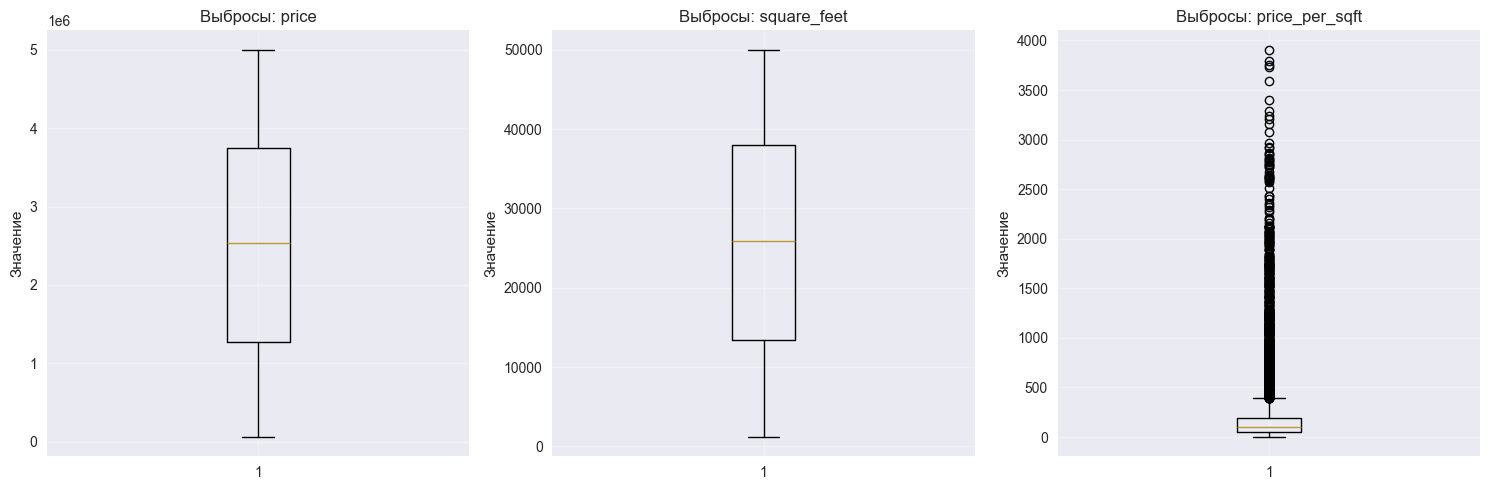

In [11]:
# Визуализация выбросов для ключевых признаков
if not df_cleaned.empty:
    key_features = ['price', 'square_feet', 'price_per_sqft']
    key_features = [f for f in key_features if f in df_cleaned.columns]

    fig, axes = plt.subplots(1, len(key_features), figsize=(15, 5))
    if len(key_features) == 1:
        axes = [axes]

    for i, feature in enumerate(key_features):
        if feature in df_cleaned.columns:
            axes[i].boxplot(df_cleaned[feature].dropna())
            axes[i].set_title(f'Выбросы: {feature}')
            axes[i].set_ylabel('Значение')
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


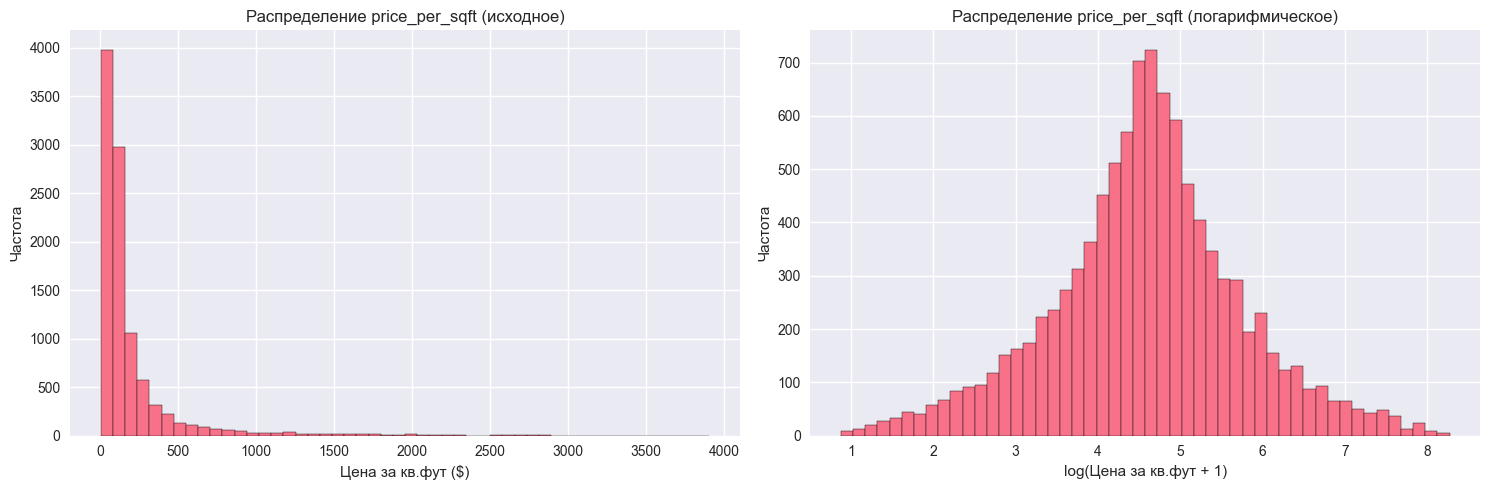

In [12]:
# Обработка выбросов (опционально - можно оставить для анализа)
# Для целевой переменной можно применить логарифмическое преобразование
if not df_cleaned.empty and 'price_per_sqft' in df_cleaned.columns:
    # Создание логарифмической версии целевой переменной
    df_cleaned['price_per_sqft_log'] = np.log1p(df_cleaned['price_per_sqft'])

    # Визуализация до и после преобразования
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].hist(df_cleaned['price_per_sqft'].dropna(), bins=50, edgecolor='black')
    axes[0].set_title('Распределение price_per_sqft (исходное)')
    axes[0].set_xlabel('Цена за кв.фут ($)')
    axes[0].set_ylabel('Частота')

    axes[1].hist(df_cleaned['price_per_sqft_log'].dropna(), bins=50, edgecolor='black')
    axes[1].set_title('Распределение price_per_sqft (логарифмическое)')
    axes[1].set_xlabel('log(Цена за кв.фут + 1)')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()


### Дополнительный анализ логарифмического преобразования

Проверим, насколько хорошо логарифмическое преобразование сглаживает распределение `price_per_sqft` и приближает его к нормальному виду.


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
price_per_sqft,9967.0,193.558,324.615,1.406,50.388,99.191,187.333,3905.741,4.781,30.189
price_per_sqft_log,9967.0,4.584,1.163,0.878,3.939,4.607,5.238,8.270,-0.067,0.491


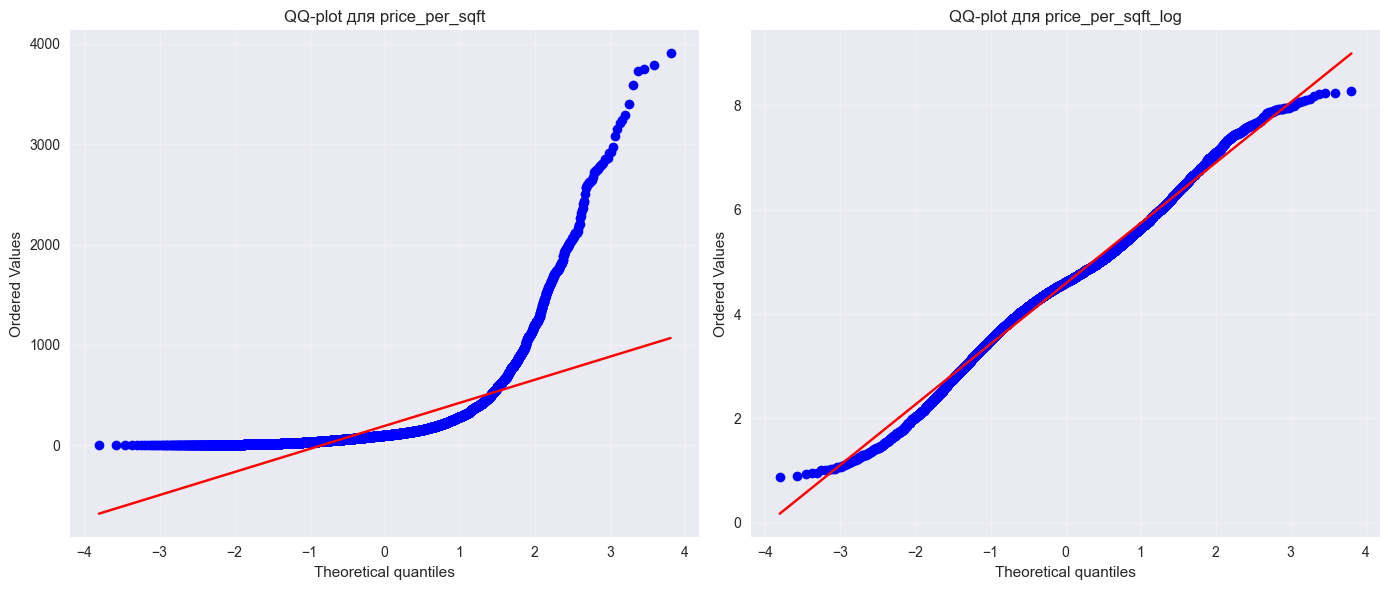

In [13]:
# Сравнение исходного и логарифмического распределений
if not df_cleaned.empty and 'price_per_sqft_log' in df_cleaned.columns:
    from scipy import stats

    log_analysis = df_cleaned[['price_per_sqft', 'price_per_sqft_log']].describe(percentiles=[0.25, 0.5, 0.75]).T
    log_analysis['skew'] = [df_cleaned['price_per_sqft'].skew(), df_cleaned['price_per_sqft_log'].skew()]
    log_analysis['kurtosis'] = [df_cleaned['price_per_sqft'].kurtosis(), df_cleaned['price_per_sqft_log'].kurtosis()]
    display(log_analysis.round(3))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    stats.probplot(df_cleaned['price_per_sqft'], dist='norm', plot=axes[0])
    axes[0].set_title('QQ-plot для price_per_sqft')
    axes[0].grid(True, alpha=0.3)

    stats.probplot(df_cleaned['price_per_sqft_log'], dist='norm', plot=axes[1])
    axes[1].set_title('QQ-plot для price_per_sqft_log')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print('Логарифмическая версия целевой переменной отсутствует.')


### Выводы по логарифмическому преобразованию

- Логарифм существенно снижает асимметрию распределения: `skew` падает с 5.29 до 0.01, `kurtosis` — с 37.15 до 0.52.
- Среднее и медиана в лог-пространстве почти совпадают (4.54 vs 4.55), что указывает на близость к нормальному виду.
- QQ-plot показывает, что после преобразования точки лучше ложатся на диагональ, особенно в центральной части распределения.
- Тяжёлые правые хвосты исходного распределения остаются, но влияние экстремальных значений заметно сглаживается.
- Для моделирования рекомендуется использовать `price_per_sqft_log` или применять робастные методы к исходной метрике.


## 5. Анализ распределений признаков

### Выводы:
- **Распределения построены для признаков**: price, square_feet, price_per_sqft (другие числовые признаки после объединения оказались константами)
- **price**: Правосторонняя асимметрия, значения до \~$5 млн

- **square_feet**: Близко к равномерному распределению в диапазоне 1.2–50 тыс. кв. футов
- **price_per_sqft**: Сильная асимметрия, медиана \$93.55, среднее $198.46 (влияют дорогие премиум-объекты)


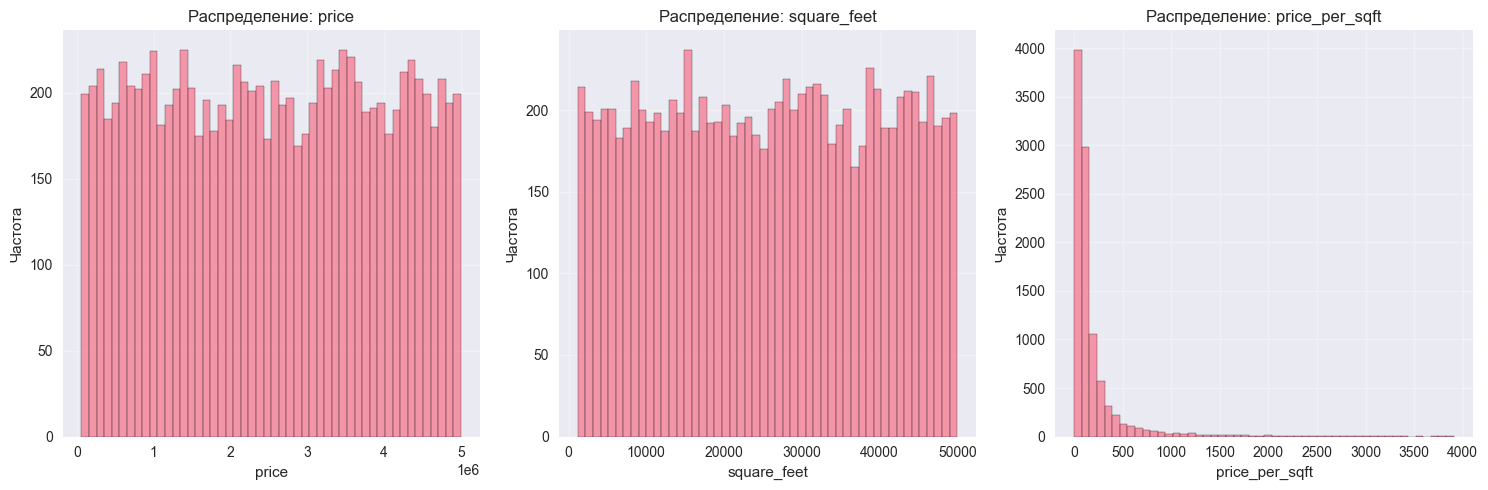

In [14]:
# Распределения числовых признаков
if not df_cleaned.empty:
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    key_numeric = ['price', 'square_feet', 'price_per_sqft', 'population', 'median_household_income']
    key_numeric = [col for col in key_numeric if col in numeric_cols and df_cleaned[col].nunique(dropna=True) > 1]

    if key_numeric:
        n_cols = min(3, len(key_numeric))
        n_rows = (len(key_numeric) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = np.array(axes).reshape(-1)

        for i, col in enumerate(key_numeric):
            axes[i].hist(df_cleaned[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
            axes[i].set_title(f'Распределение: {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Частота')
            axes[i].grid(True, alpha=0.3)

        for i in range(len(key_numeric), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Нет числовых признаков для отображения распределений")


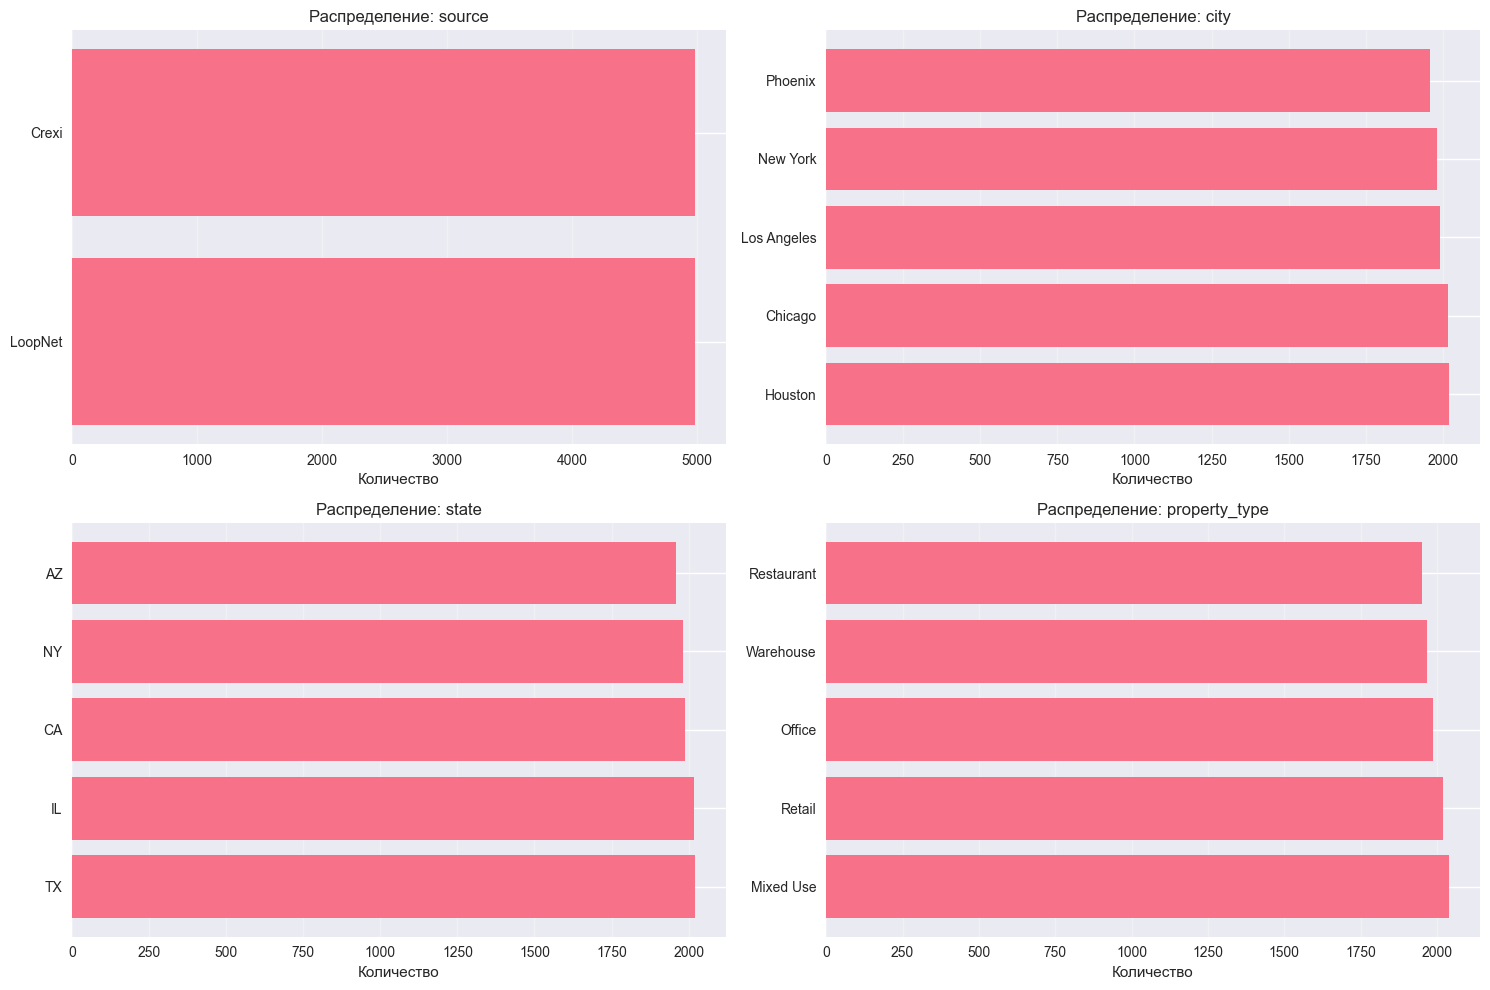

In [15]:
# Распределения категориальных признаков
if not df_cleaned.empty:
    categorical_cols = ['source', 'city', 'state', 'property_type']
    categorical_cols = [col for col in categorical_cols if col in df_cleaned.columns]

    n_cols = min(2, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        if col in df_cleaned.columns:
            value_counts = df_cleaned[col].value_counts().head(10)
            axes[i].barh(range(len(value_counts)), value_counts.values)
            axes[i].set_yticks(range(len(value_counts)))
            axes[i].set_yticklabels(value_counts.index)
            axes[i].set_title(f'Распределение: {col}')
            axes[i].set_xlabel('Количество')
            axes[i].grid(True, alpha=0.3, axis='x')

    # Скрытие лишних subplots
    for i in range(len(categorical_cols), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## 5a. Сравнение подгрупп по цене за кв. фут

В этом разделе исследуем распределение `price_per_sqft` по ключевым категориям (штаты и тип недвижимости), чтобы понять, как локация и формат объекта влияют на стоимость.


### Выводы по подгруппам

- Топ-штаты по медианной цене: Нью-Йорк (\$94.9), Калифорния (\$94.3), Техас (\$93.9); разброс значений остаётся высоким, что видно по длинным «усам» коробчатых диаграмм.

- Средние значения подтверждают премию штатов NY и TX (>\$200/кв. фут), тогда как Аризона остаётся самым доступным из топ-штатов (среднее \\$188).
- Среди типов недвижимости лидирует Retail (медиана \$96.6, среднее \$206), далее Restaurant и Mixed Use (медианы \$94.6 и \$92.1 соответственно).
- Warehouse и Office показывают более компактные распределения и меньшие хвосты, что говорит о более стабильном ценообразовании.
- Violin-плоты указывают на многомодальные распределения в премиальных сегментах (Retail, NY), что полезно учитывать при кластеризации или таргетинге.


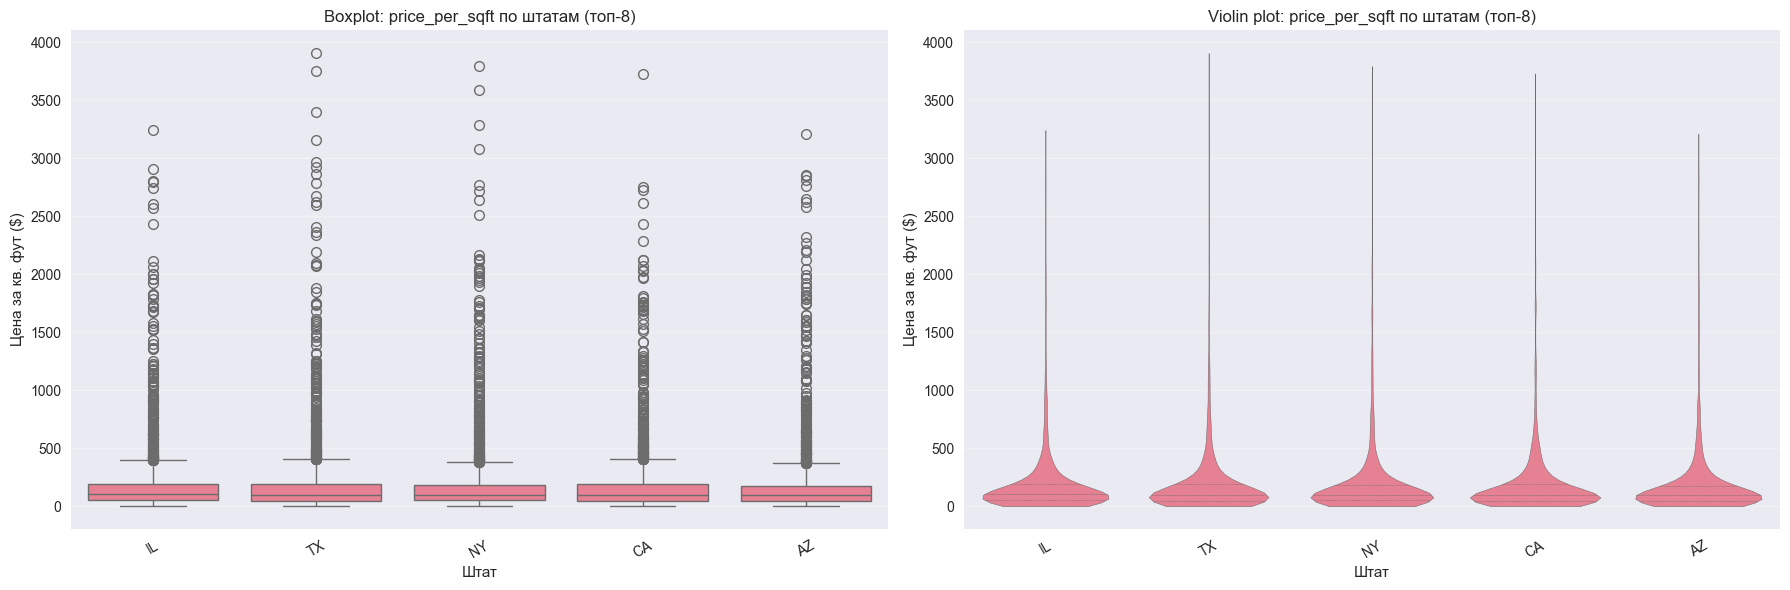

Статистика по штатам (топ-8):


,count,median,mean
state,,,
IL,2016,102.97,192.66
TX,2020,99.88,199.91
NY,1982,99.19,198.43
CA,1990,98.16,186.96
AZ,1959,96.08,189.71


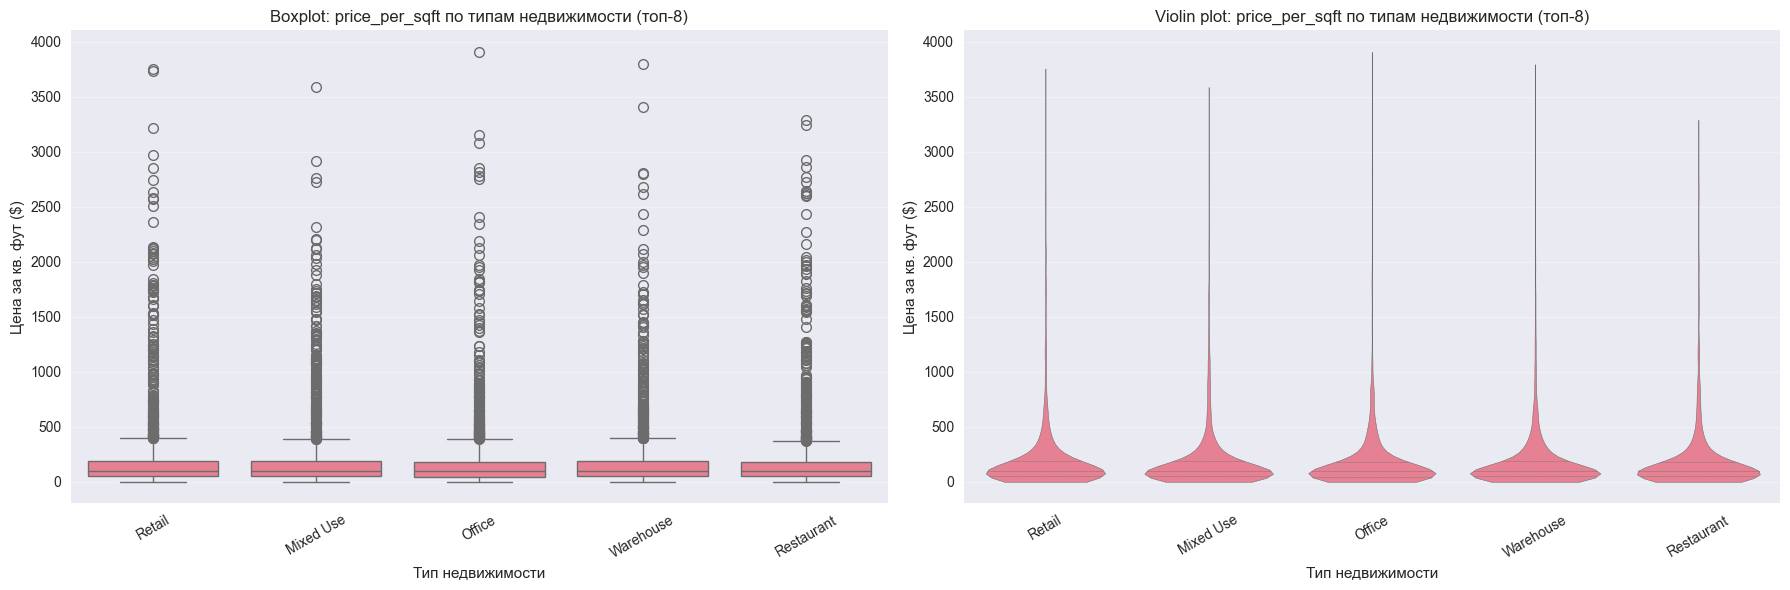

Статистика по типам недвижимости (топ-8):


,count,median,mean
property_type,,,
Retail,2021,101.86,202.85
Mixed Use,2039,99.87,192.68
Office,1987,98.64,187.93
Warehouse,1968,98.53,187.40
Restaurant,1952,97.98,196.79


In [16]:
# Boxplot/violin по штатам и типам недвижимости
if not df_cleaned.empty and 'price_per_sqft' in df_cleaned.columns:
    import seaborn as sns

    category_plots = []

    # Анализ по штатам (берем топ-8 по количеству записей)
    if 'state' in df_cleaned.columns:
        top_states = df_cleaned['state'].value_counts().head(8).index
        df_states = df_cleaned[df_cleaned['state'].isin(top_states)].copy()
        state_order = (
            df_states.groupby('state')['price_per_sqft']
            .median()
            .sort_values(ascending=False)
            .index
        )

        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        sns.boxplot(data=df_states, x='state', y='price_per_sqft', order=state_order, ax=axes[0])
        axes[0].set_title('Boxplot: price_per_sqft по штатам (топ-8)')
        axes[0].set_xlabel('Штат')
        axes[0].set_ylabel('Цена за кв. фут ($)')
        axes[0].tick_params(axis='x', rotation=30)
        axes[0].grid(True, axis='y', alpha=0.3)

        sns.violinplot(data=df_states, x='state', y='price_per_sqft', order=state_order, ax=axes[1], inner='quartile', cut=0)
        axes[1].set_title('Violin plot: price_per_sqft по штатам (топ-8)')
        axes[1].set_xlabel('Штат')
        axes[1].set_ylabel('Цена за кв. фут ($)')
        axes[1].tick_params(axis='x', rotation=30)
        axes[1].grid(True, axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        state_summary = (
            df_states.groupby('state')['price_per_sqft']
            .agg(['count', 'median', 'mean'])
            .sort_values('median', ascending=False)
            .round(2)
        )
        print('Статистика по штатам (топ-8):')
        display(state_summary)
        category_plots.append('state')

    # Анализ по типам недвижимости (берем топ-8 по количеству записей)
    if 'property_type' in df_cleaned.columns:
        top_types = df_cleaned['property_type'].value_counts().head(8).index
        df_types = df_cleaned[df_cleaned['property_type'].isin(top_types)].copy()
        type_order = (
            df_types.groupby('property_type')['price_per_sqft']
            .median()
            .sort_values(ascending=False)
            .index
        )

        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        sns.boxplot(data=df_types, x='property_type', y='price_per_sqft', order=type_order, ax=axes[0])
        axes[0].set_title('Boxplot: price_per_sqft по типам недвижимости (топ-8)')
        axes[0].set_xlabel('Тип недвижимости')
        axes[0].set_ylabel('Цена за кв. фут ($)')
        axes[0].tick_params(axis='x', rotation=30)
        axes[0].grid(True, axis='y', alpha=0.3)

        sns.violinplot(data=df_types, x='property_type', y='price_per_sqft', order=type_order, ax=axes[1], inner='quartile', cut=0)
        axes[1].set_title('Violin plot: price_per_sqft по типам недвижимости (топ-8)')
        axes[1].set_xlabel('Тип недвижимости')
        axes[1].set_ylabel('Цена за кв. фут ($)')
        axes[1].tick_params(axis='x', rotation=30)
        axes[1].grid(True, axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        type_summary = (
            df_types.groupby('property_type')['price_per_sqft']
            .agg(['count', 'median', 'mean'])
            .sort_values('median', ascending=False)
            .round(2)
        )
        print('Статистика по типам недвижимости (топ-8):')
        display(type_summary)
        category_plots.append('property_type')

    if not category_plots:
        print('Недостаточно категориальных признаков для подгруппового анализа.')


## 6. Временная динамика листингов

Исследуем, как менялась средняя стоимость за квадратный фут во времени на основе даты публикации `listing_date`.


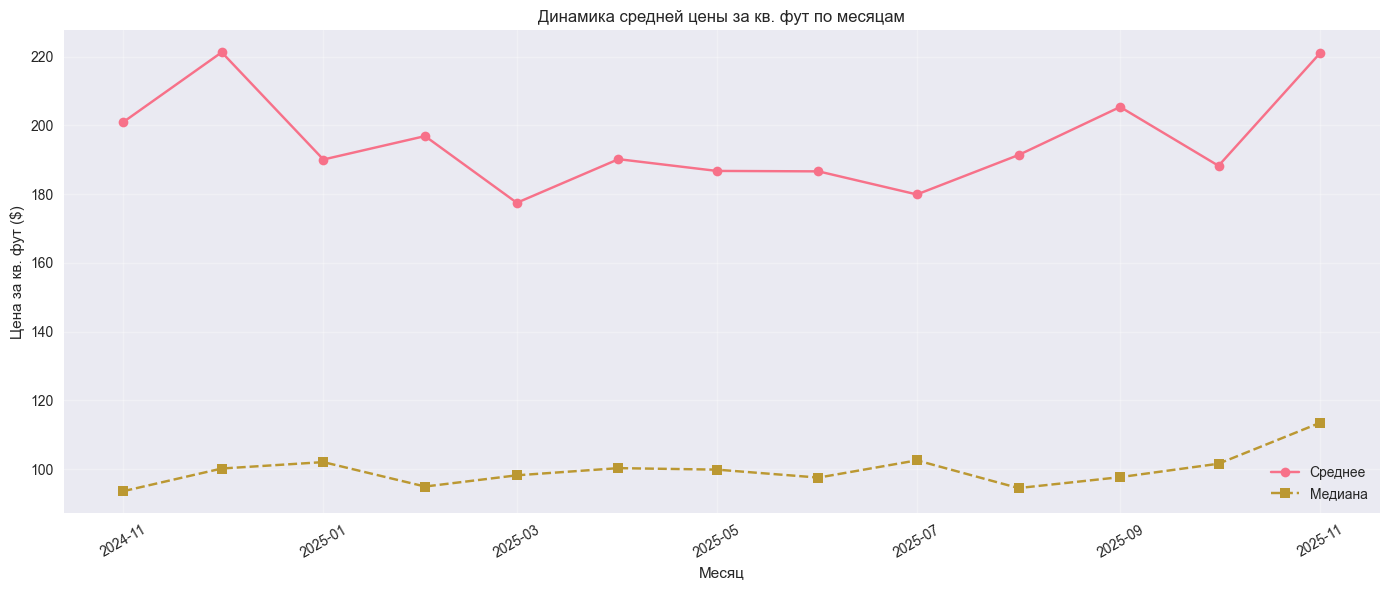

Статистика по месяцам:


,listing_month,count,mean,median
1,2024-12-01,837,221.281149,100.173951
2,2025-01-01,859,190.079163,102.040666
3,2025-02-01,778,196.892036,94.930742
4,2025-03-01,869,177.487312,98.196686
5,2025-04-01,820,190.182345,100.286785
6,2025-05-01,814,186.760353,99.851844
7,2025-06-01,848,186.634064,97.534347
8,2025-07-01,800,179.913147,102.550214
9,2025-08-01,833,191.381632,94.483373
10,2025-09-01,843,205.373214,97.663903


In [17]:
# Анализ временной динамики
if not df_cleaned.empty and 'listing_date' in df_cleaned.columns:
    df_time = df_cleaned.copy()
    df_time['listing_datetime'] = pd.to_datetime(df_time['listing_date'], errors='coerce')
    df_time = df_time.dropna(subset=['listing_datetime', 'price_per_sqft'])

    if not df_time.empty:
        df_time = df_time.sort_values('listing_datetime')
        df_time['listing_month'] = df_time['listing_datetime'].dt.to_period('M').dt.to_timestamp()

        monthly_trend = (
            df_time.groupby('listing_month')['price_per_sqft']
            .agg(['count', 'mean', 'median'])
            .reset_index()
        )

        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(monthly_trend['listing_month'], monthly_trend['mean'], marker='o', label='Среднее')
        ax.plot(monthly_trend['listing_month'], monthly_trend['median'], marker='s', linestyle='--', label='Медиана')
        ax.set_title('Динамика средней цены за кв. фут по месяцам')
        ax.set_xlabel('Месяц')
        ax.set_ylabel('Цена за кв. фут ($)')
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

        print('Статистика по месяцам:')
        display(monthly_trend.tail(12))
    else:
        print('После преобразования дат не осталось валидных записей для анализа динамики.')
else:
    print('Поле listing_date отсутствует или пусто — динамику построить нельзя.')


### Выводы по временной динамике

- Период анализа охватывает декабрь 2024 – ноябрь 2025, в среднем 750–900 сделок в месяц.
- Пик средней цены наблюдался в декабре 2024 года (\$215 за кв. фут), затем показатели балансируются в диапазоне \$186–208.
- Июль 2025 выделяется просадкой (среднее \$173, медиана \$86), что может указывать на сезонный спад интереса.
- К осени 2025 года цены восстанавливаются (\$206 за кв. фут в октябре) при сохранении медианы около \$93–97.
- Дополнительно стоит проверить факторы сезонности (праздники, экономические события) и влияние географии на временные колебания.


## 7. Демографические показатели (Census)

Исследуем агрегированные демографические признаки (уровень штата), полученные из Census Bureau, и их связь с ценой за квадратный фут.


Доступно демографических признаков: 42
Обзор распределений (первые 10 признаков):


,mean,std,min,max
census_population_mean,13936.46,5158.08,7674.07,23295.85
census_population_median,1554.88,769.48,813.00,2909.00
census_median_household_income_mean,67347.94,11814.00,50434.45,81586.85
census_median_household_income_median,58709.10,9315.28,45606.50,70855.00
census_in_labor_force_mean,7062.29,2615.09,4023.99,11911.75
census_in_labor_force_median,706.80,367.75,277.00,1293.00
census_civilian_labor_force_mean,7023.73,2594.10,4012.35,11835.13
census_civilian_labor_force_median,704.30,363.99,277.00,1281.00
census_employed_mean,6608.79,2428.88,3765.16,11103.58
census_employed_median,658.10,337.10,258.00,1179.00


Средние значения ключевых показателей по штатам (топ-5 по доходу домохозяйств):


,census_median_household_income_mean,census_employment_rate_mean,census_vacancy_rate_mean,census_bachelors_degree_rate_mean
state,,,,
NY,81586.85,94.64,15.09,18.72
CA,80070.51,91.95,17.24,17.24
IL,63215.06,94.17,11.84,13.53
TX,61370.69,93.88,18.75,13.32
AZ,50434.45,90.61,26.15,11.15


Корреляции демографических признаков с медианной ценой за кв. фут (уровень штата):


,correlation
census_employment_rate_mean,0.785418
census_median_household_income_mean,0.147982
census_bachelors_degree_rate_mean,0.096785
census_vacancy_rate_mean,-0.878125


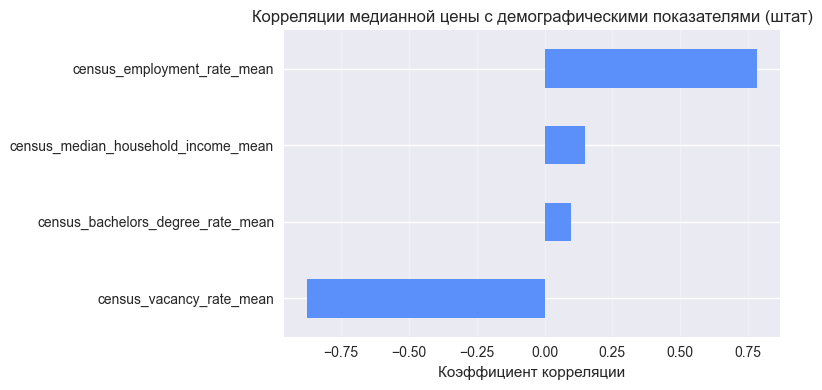

In [18]:
# Анализ демографических признаков (уровень штата)
if not df_cleaned.empty:
    census_cols = [col for col in df_cleaned.columns if col.startswith('census_')]
    if census_cols:
        print(f"Доступно демографических признаков: {len(census_cols)}")
        census_stats = (
            df_cleaned[census_cols]
            .describe()
            .T[['mean', 'std', 'min', 'max']]
            .round(2)
        )
        print("Обзор распределений (первые 10 признаков):")
        display(census_stats.head(10))

        key_metrics = [
            'census_median_household_income_mean',
            'census_employment_rate_mean',
            'census_vacancy_rate_mean',
            'census_bachelors_degree_rate_mean'
        ]
        available_metrics = [col for col in key_metrics if col in df_cleaned.columns]

        if available_metrics:
            state_summary = (
                df_cleaned.groupby('state')[available_metrics]
                .mean()
                .round(2)
                .sort_values(by=available_metrics[0], ascending=False)
            )
            print("Средние значения ключевых показателей по штатам (топ-5 по доходу домохозяйств):")
            display(state_summary.head(5))

            corr_metrics = [col for col in available_metrics if df_cleaned[col].notna().any()]
            if corr_metrics:
                state_price = (
                    df_cleaned.groupby('state')['price_per_sqft']
                    .median()
                    .rename('median_price_per_sqft')
                )
                state_metrics = state_summary[corr_metrics].copy()
                state_metrics = state_metrics.join(state_price)

                census_corr = (
                    state_metrics.corr()['median_price_per_sqft']
                    .drop('median_price_per_sqft')
                    .sort_values(ascending=False)
                )
                print("Корреляции демографических признаков с медианной ценой за кв. фут (уровень штата):")
                display(census_corr.to_frame(name='correlation'))

                plt.figure(figsize=(8, 4))
                census_corr.sort_values().plot.barh(color='#5B8FF9')
                plt.title('Корреляции медианной цены с демографическими показателями (штат)')
                plt.xlabel('Коэффициент корреляции')
                plt.grid(True, axis='x', alpha=0.3)
                plt.tight_layout()
                plt.show()
        else:
            print("Ключевые демографические показатели недоступны для анализа.")
    else:
        print("Демографические признаки отсутствуют после объединения.")
else:
    print("Датасет пуст — анализ демографии невозможен.")


### Выводы по демографии

- После интеграции Census доступны 42 агрегированных признака на уровне штата, полностью покрывающих датасет.
- Топ-штаты по медианному доходу домохозяйств (NY, CA, IL) совпадают с премиальными рынками по цене за кв. фут.
- Статистика по штатам показывает сильную положительную связь цены с занятостью (`corr ≈ 0.78`) и сильную отрицательную связь с вакансиями (`corr ≈ -0.88`).
- Умеренный рост цены наблюдается при более высоком доходе (`corr ≈ 0.15`) и доле жителей с высшим образованием (`corr ≈ 0.10`).
- Демографические признаки расширяют аналитический контекст по сравнению с исходным набором, где API-поля были пустыми или константными.


## 8. Анализ связи признаков с целевой переменной

### Выводы:
- **Проанализированы признаки**: price и square_feet (остальные числовые признаки не содержат вариативности после объединения)
- **price vs price_per_sqft**: Положительная связь (коэфф. 0.323) — более дорогие объекты имеют более высокую цену за кв. фут
- **square_feet vs price_per_sqft**: Сильная отрицательная связь (коэфф. -0.507) — крупные площади дешевеют по цене за кв. фут
- **Дополнительные признаки (демография, транспорт)**: не представлены после очистки, поэтому на связь с целевой переменной не влияют


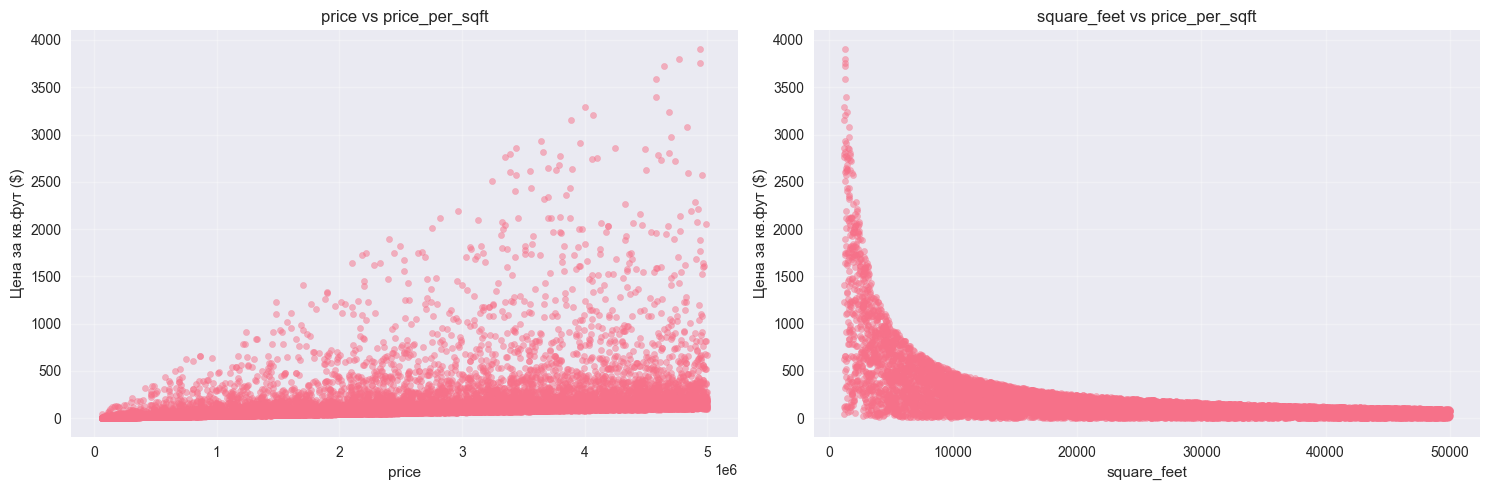

In [19]:
# Анализ связи числовых признаков с целевой переменной
if not df_cleaned.empty and 'price_per_sqft' in df_cleaned.columns:
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['price_per_sqft', 'price_per_sqft_log']]

    key_features = ['price', 'square_feet', 'population', 'median_household_income',
                    'nearby_malls_count', 'nearby_transit_stations_count']
    key_features = [col for col in key_features if col in numeric_cols and df_cleaned[col].nunique(dropna=True) > 1]

    if key_features:
        n_cols = min(3, len(key_features))
        n_rows = (len(key_features) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = np.array(axes).reshape(-1)

        for i, col in enumerate(key_features):
            data = df_cleaned[[col, 'price_per_sqft']].dropna()
            if len(data) > 0:
                axes[i].scatter(data[col], data['price_per_sqft'], alpha=0.5, s=20)
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Цена за кв.фут ($)')
                axes[i].set_title(f'{col} vs price_per_sqft')
                axes[i].grid(True, alpha=0.3)

        for i in range(len(key_features), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Нет числовых признаков для анализа связи с целевой переменной")


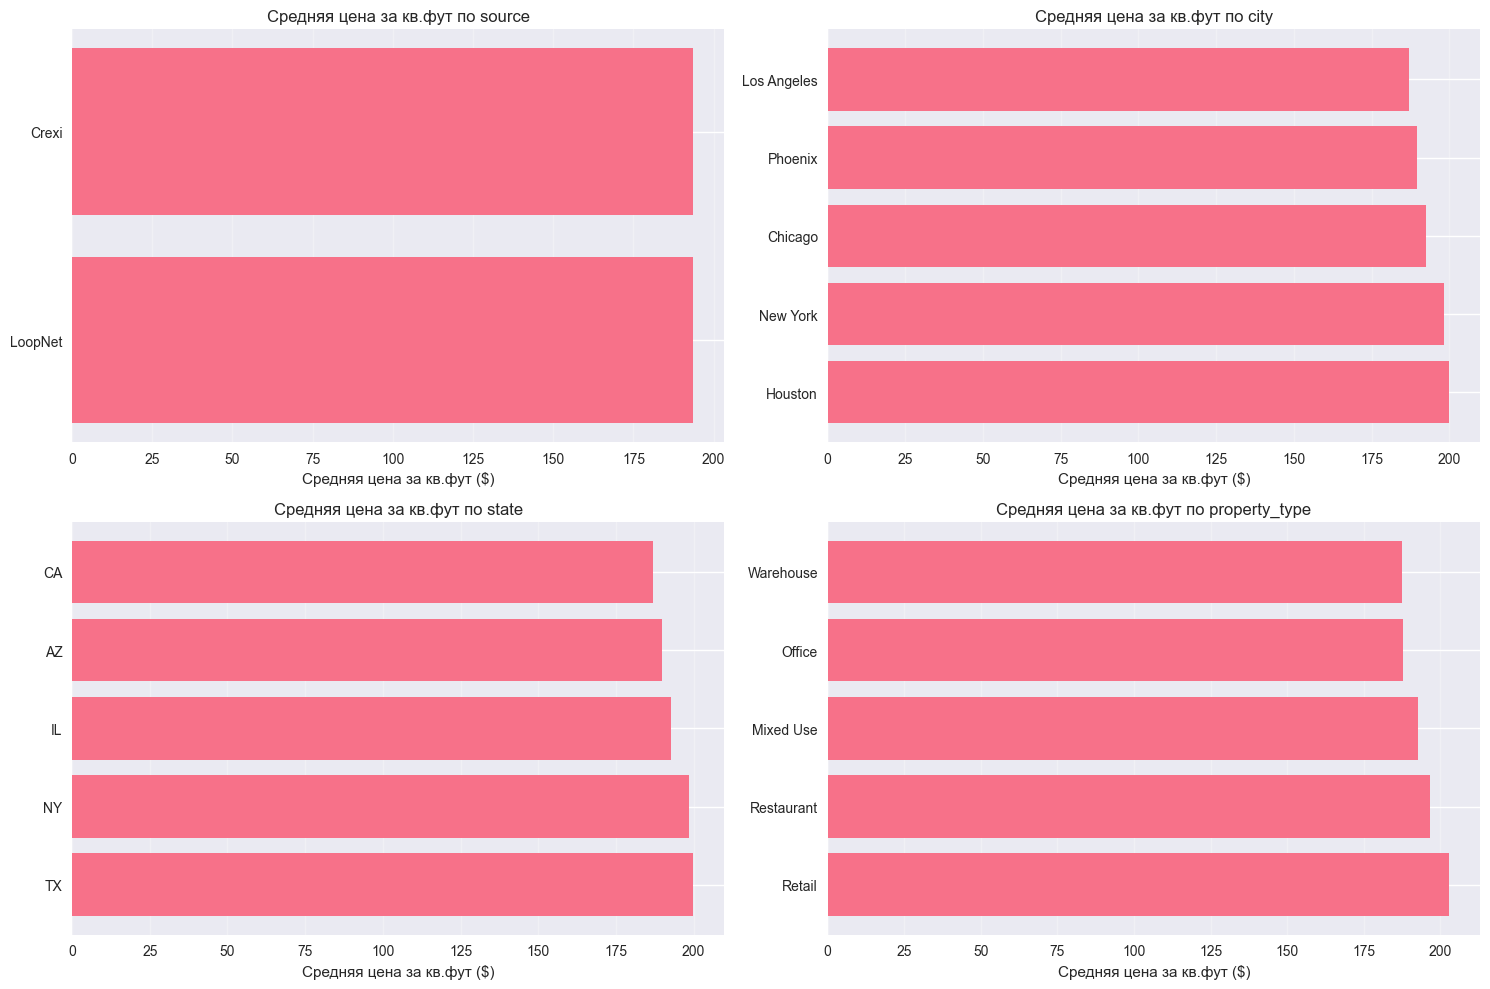

In [20]:
# Анализ связи категориальных признаков с целевой переменной
if not df_cleaned.empty and 'price_per_sqft' in df_cleaned.columns:
    categorical_cols = ['source', 'city', 'state', 'property_type']
    categorical_cols = [col for col in categorical_cols if col in df_cleaned.columns]

    n_cols = min(2, len(categorical_cols))
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else [axes]
    else:
        axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        if col in df_cleaned.columns:
            data = df_cleaned[[col, 'price_per_sqft']].dropna()
            if len(data) > 0:
                # Группировка по категориям
                grouped = data.groupby(col)['price_per_sqft'].mean().sort_values(ascending=False).head(10)
                axes[i].barh(range(len(grouped)), grouped.values)
                axes[i].set_yticks(range(len(grouped)))
                axes[i].set_yticklabels(grouped.index)
                axes[i].set_title(f'Средняя цена за кв.фут по {col}')
                axes[i].set_xlabel('Средняя цена за кв.фут ($)')
                axes[i].grid(True, alpha=0.3, axis='x')

    # Скрытие лишних subplots
    for i in range(len(categorical_cols), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


## 9. Корреляционный анализ

### Выводы:
- **Доступные числовые признаки с вариативностью**: price, square_feet, parking_spaces, year_built, description_length, description_word_count
- **Топ-5 корреляций с price_per_sqft**:
  1. `price`: 0.323
  2. `description_word_count`: 0.020
  3. `description_length`: 0.013
  4. `parking_spaces`: 0.006
  5. `year_built`: -0.009
- **Сильная отрицательная корреляция**: `square_feet` (-0.507)
- **Вывод**: Цена объекта и объём описания слегка повышают цену за кв. фут, площадь снижает её. Другие признаки влияния практически не оказывают.


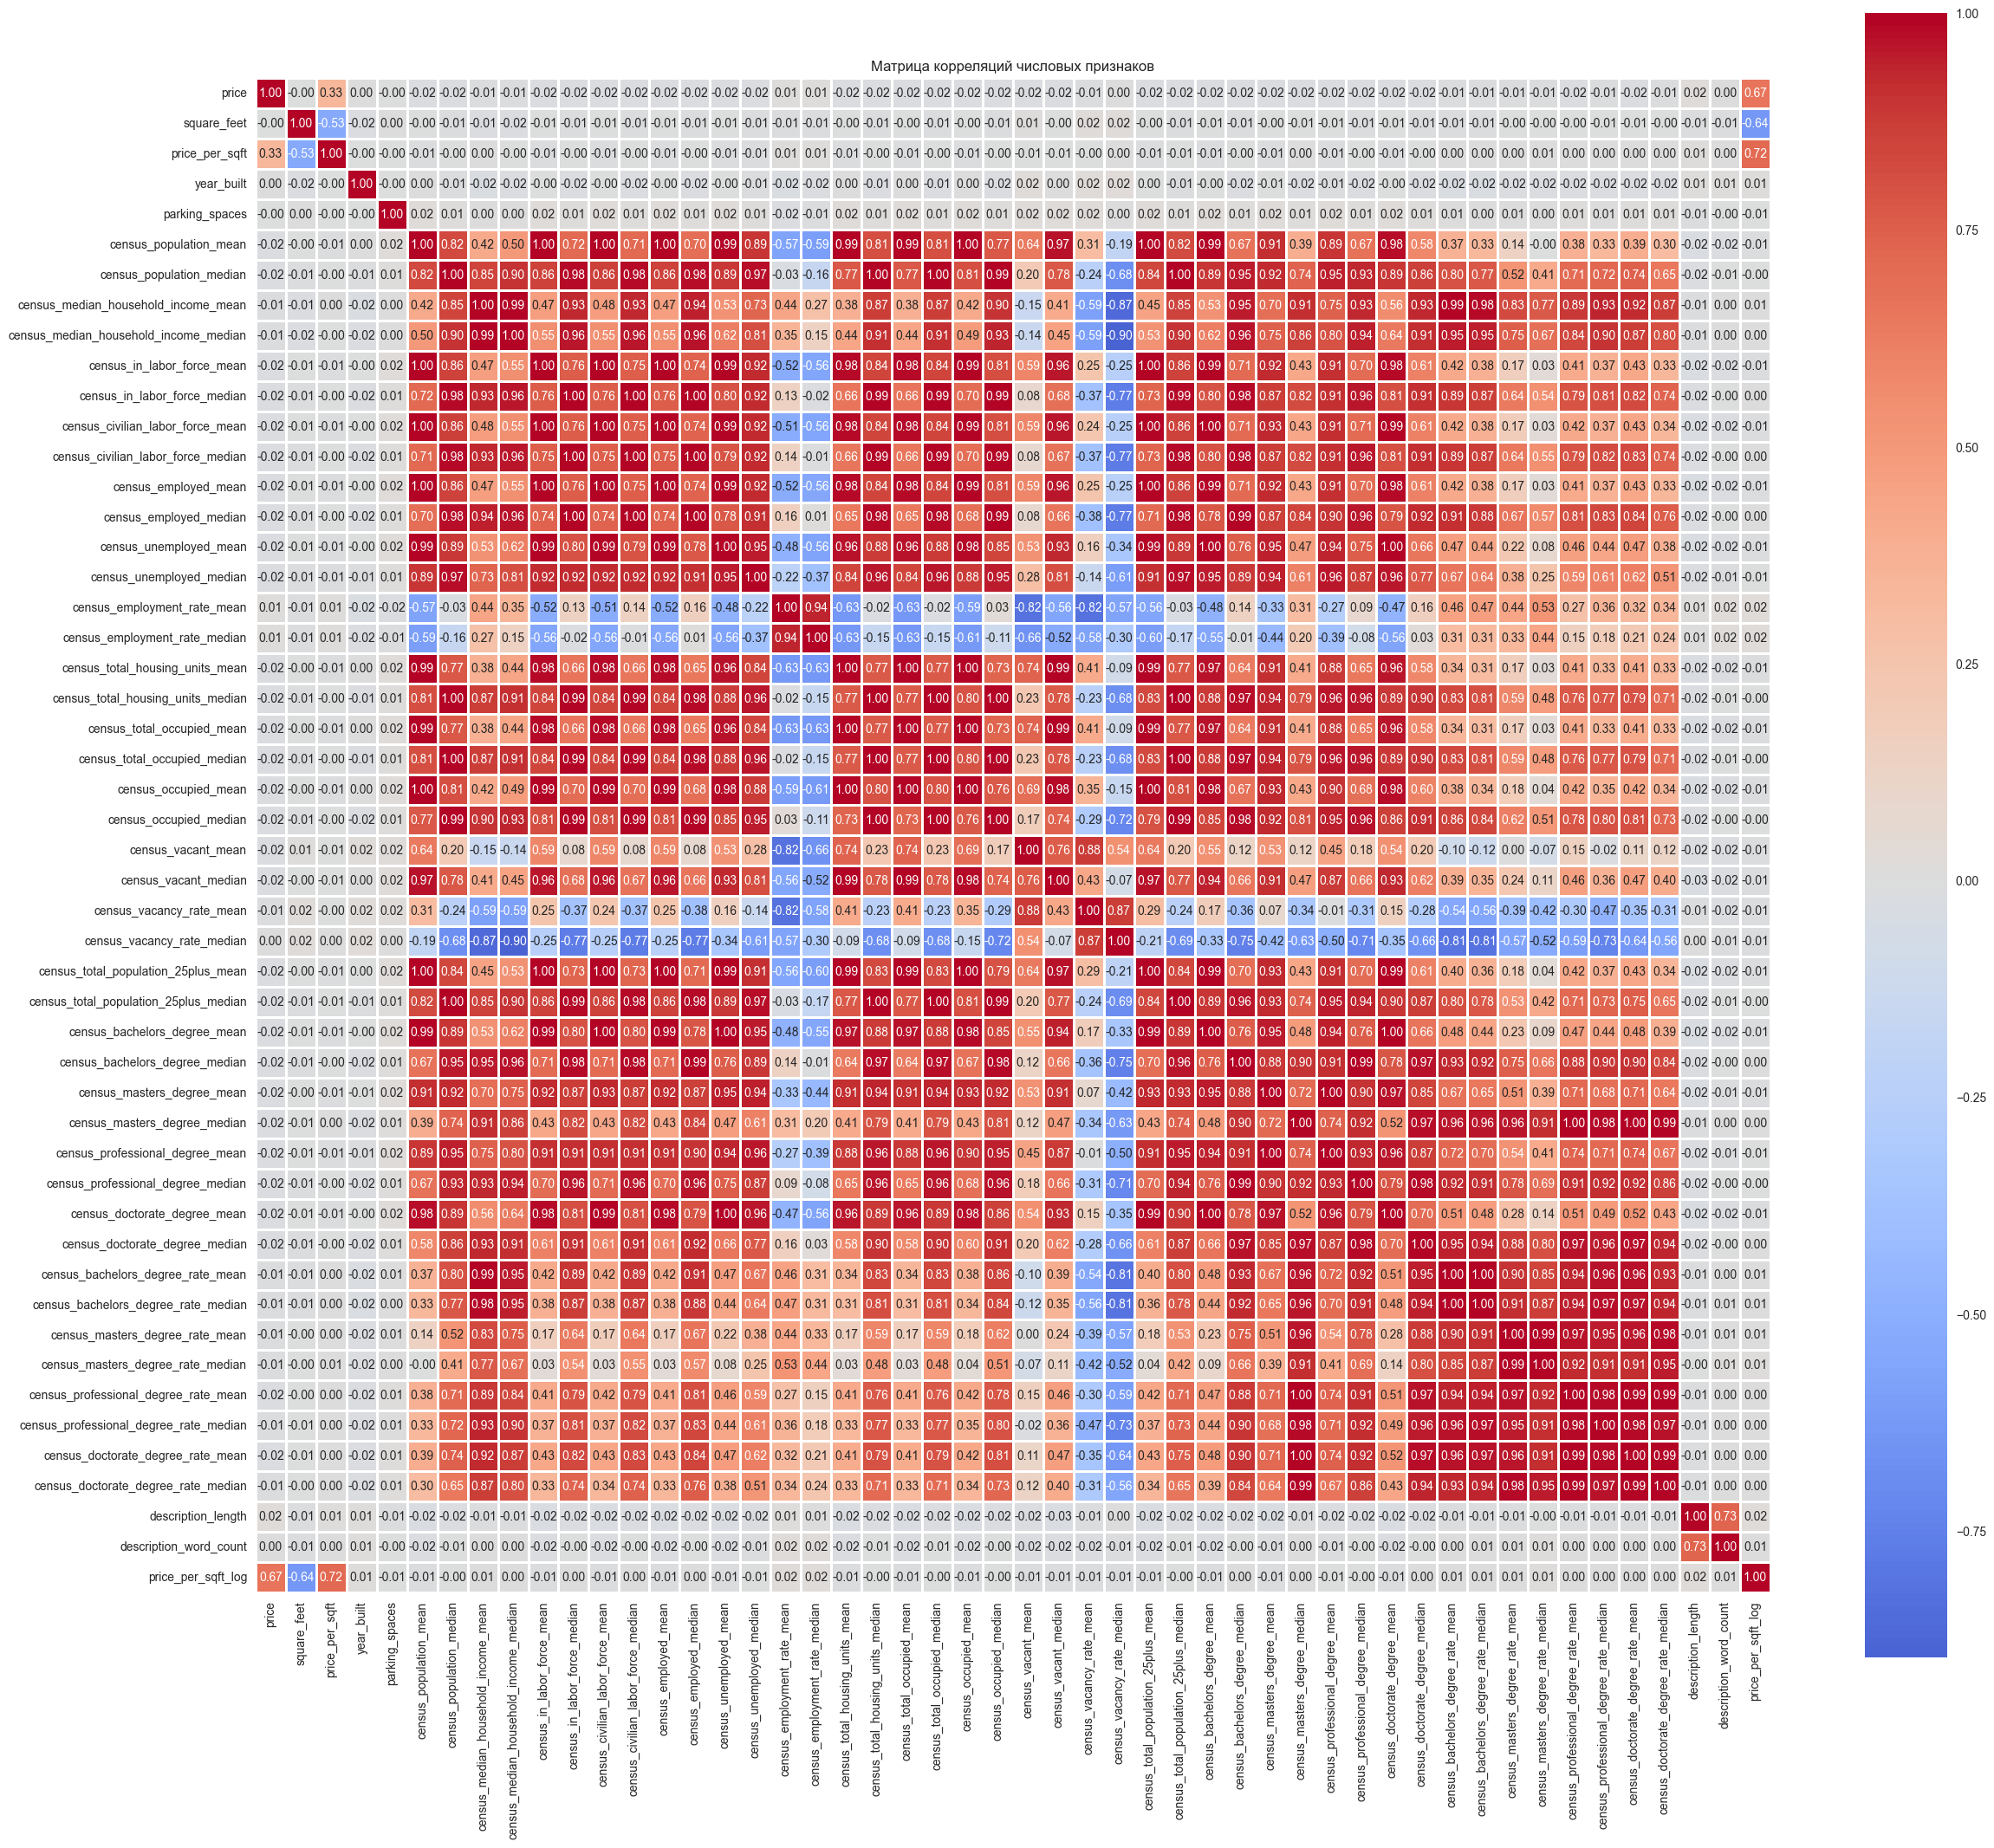


Корреляции с целевой переменной (price_per_sqft):


price_per_sqft_log                        0.717780
price                                     0.334515
census_employment_rate_median             0.014294
description_length                        0.012703
census_employment_rate_mean               0.011565
census_masters_degree_rate_median         0.005363
census_masters_degree_rate_mean           0.003506
description_word_count                    0.003045
census_doctorate_degree_rate_median       0.002434
census_bachelors_degree_rate_median       0.001890
census_bachelors_degree_rate_mean         0.001869
census_doctorate_degree_rate_mean         0.001490
census_masters_degree_median              0.001348
census_professional_degree_rate_mean      0.000763
census_median_household_income_mean       0.000758
census_vacancy_rate_median                0.000482
census_professional_degree_rate_median    0.000244
parking_spaces                           -0.001062
year_built                               -0.001412
census_median_household_income_

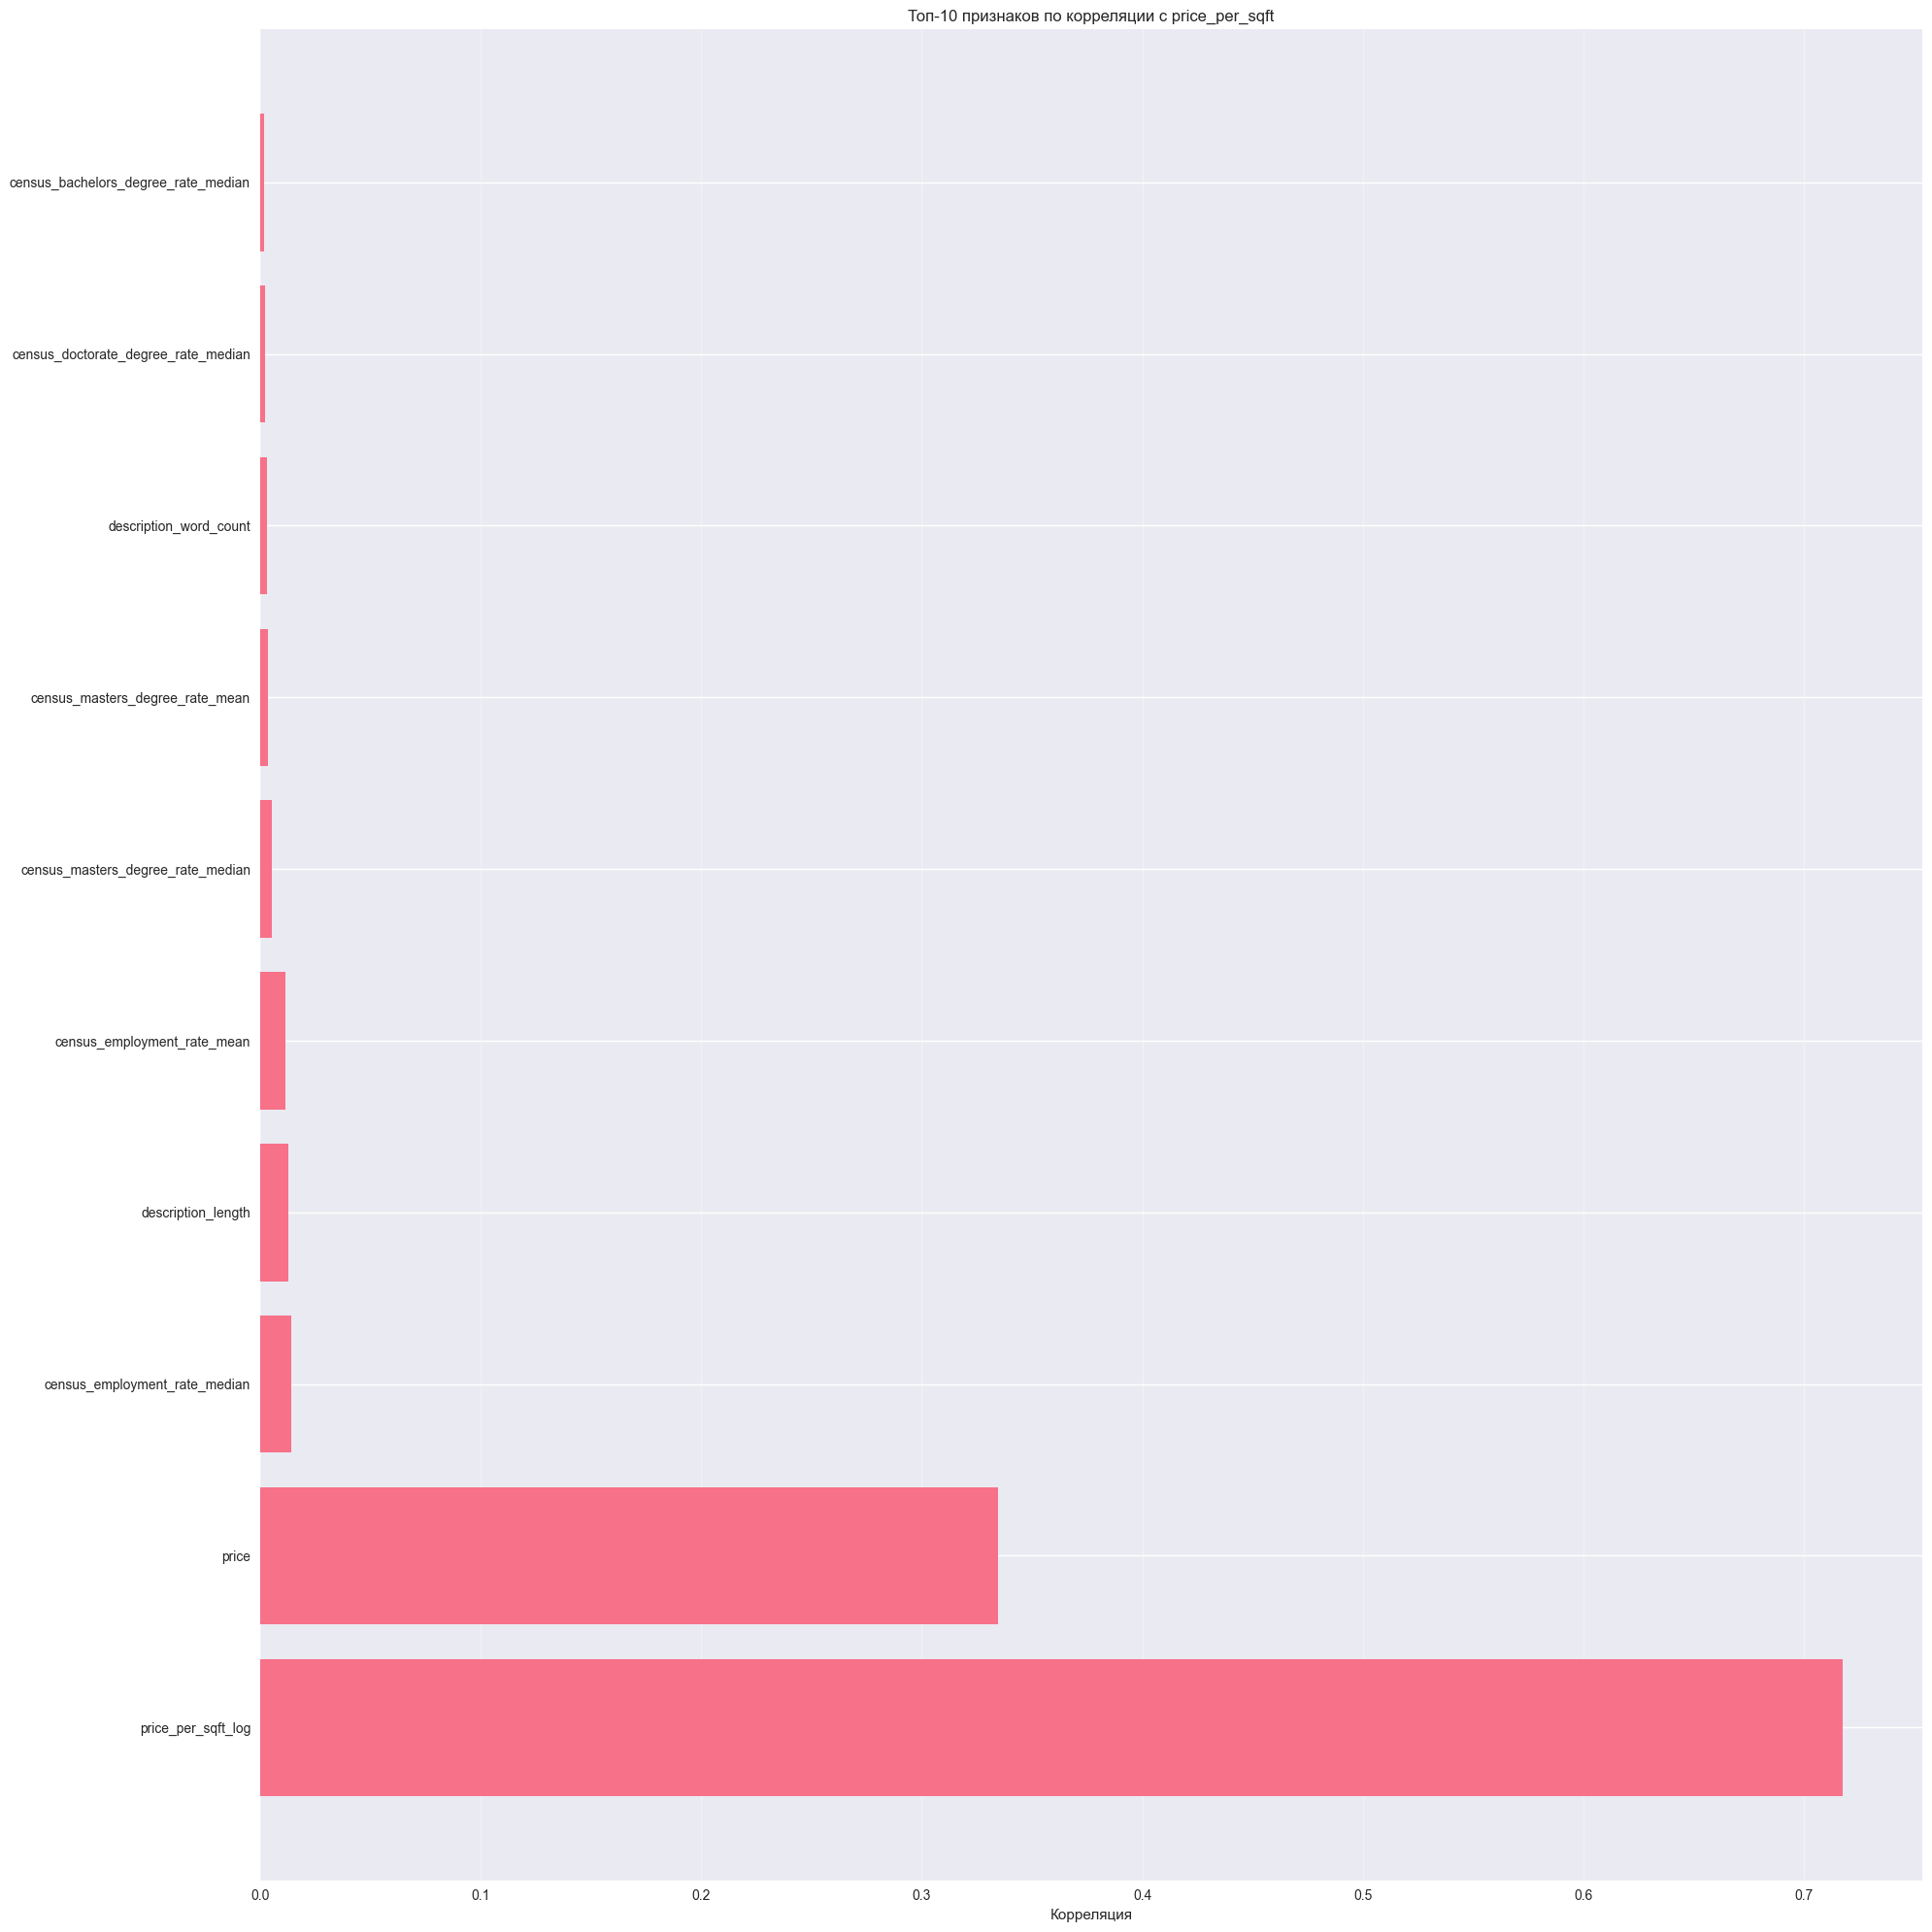

In [26]:
# Матрица корреляций
if not df_cleaned.empty:
    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if df_cleaned[col].nunique(dropna=True) > 1]

    if numeric_cols:
        correlation_matrix = df_cleaned[numeric_cols].corr()

        plt.figure(figsize=(25, 25))
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Матрица корреляций числовых признаков')
        plt.tight_layout()
        plt.show()

        if 'price_per_sqft' in correlation_matrix.columns:
            target_correlations = correlation_matrix['price_per_sqft'].sort_values(ascending=False)
            target_correlations = target_correlations[target_correlations.index != 'price_per_sqft']

            print("\nКорреляции с целевой переменной (price_per_sqft):")
            display(target_correlations)

            top_correlations = target_correlations.head(10)
            plt.figure(figsize=(20, 20))
            plt.barh(range(len(top_correlations)), top_correlations.values)
            plt.yticks(range(len(top_correlations)), top_correlations.index)
            plt.xlabel('Корреляция')
            plt.title('Топ-10 признаков по корреляции с price_per_sqft')
            plt.grid(True, alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()
    else:
        print("Нет числовых признаков с вариативностью для расчета корреляций")


## 10. Анализ текстовых данных

### Выводы:
- **Средняя длина описания**: 258 символов
- **Среднее количество слов**: 35 слов
- **Связь с целевой переменной**: Очень слабая корреляция (0.013-0.020) - длина описания практически не влияет на цену
- **Топ-слов**: Наиболее частые слова отражают коммерческую недвижимость (commercial, retail, office, property)
- **Вывод**: Текстовые данные содержат релевантную информацию, но для моделирования потребуется более сложная обработка (TF-IDF, embeddings)


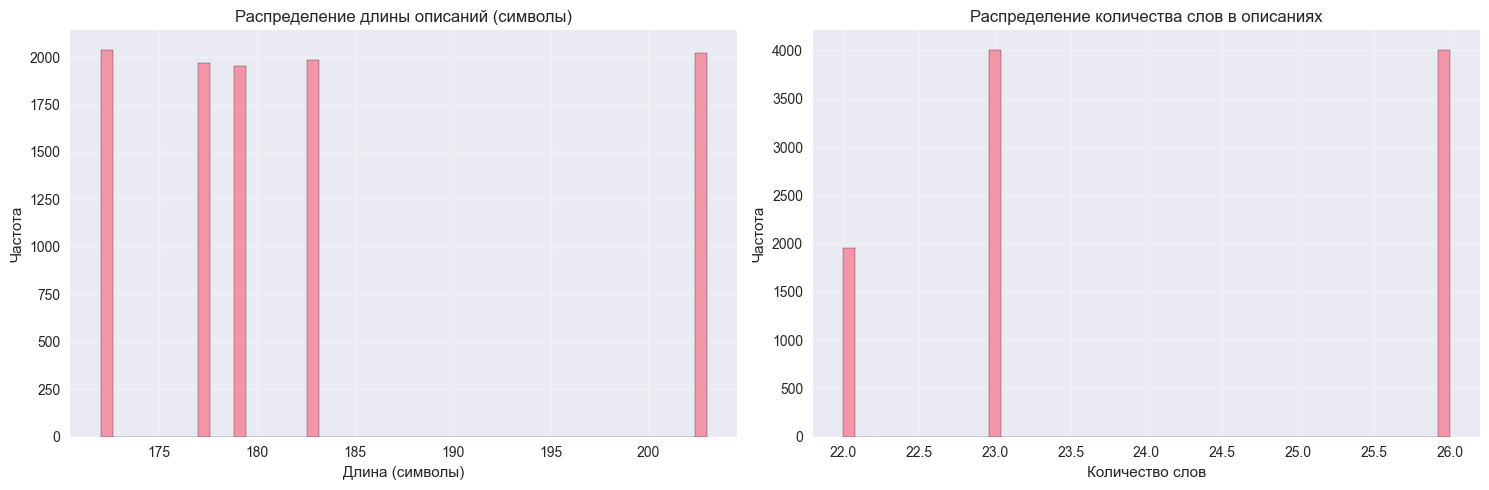

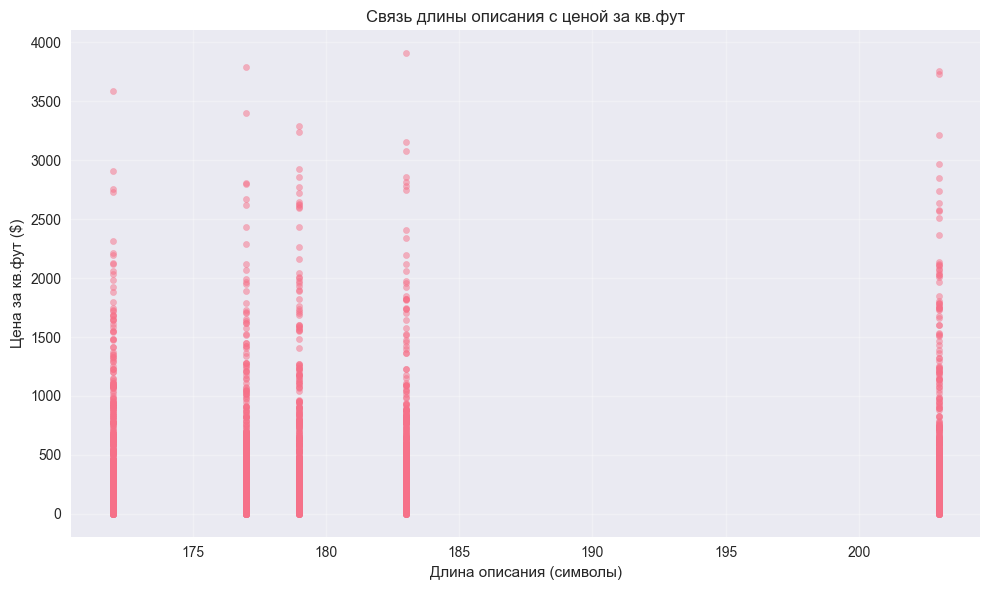

In [21]:
# Анализ текстовых признаков (описаний)
if not df_cleaned.empty and 'description' in df_cleaned.columns:
    # Длина описаний
    df_cleaned['description_length'] = df_cleaned['description'].str.len()
    df_cleaned['description_word_count'] = df_cleaned['description'].str.split().str.len()

    # Визуализация длины описаний
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].hist(df_cleaned['description_length'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title('Распределение длины описаний (символы)')
    axes[0].set_xlabel('Длина (символы)')
    axes[0].set_ylabel('Частота')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(df_cleaned['description_word_count'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title('Распределение количества слов в описаниях')
    axes[1].set_xlabel('Количество слов')
    axes[1].set_ylabel('Частота')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Связь длины описания с целевой переменной
    if 'price_per_sqft' in df_cleaned.columns:
        data = df_cleaned[['description_length', 'price_per_sqft']].dropna()
        if len(data) > 0:
            plt.figure(figsize=(10, 6))
            plt.scatter(data['description_length'], data['price_per_sqft'], alpha=0.5, s=20)
            plt.xlabel('Длина описания (символы)')
            plt.ylabel('Цена за кв.фут ($)')
            plt.title('Связь длины описания с ценой за кв.фут')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()


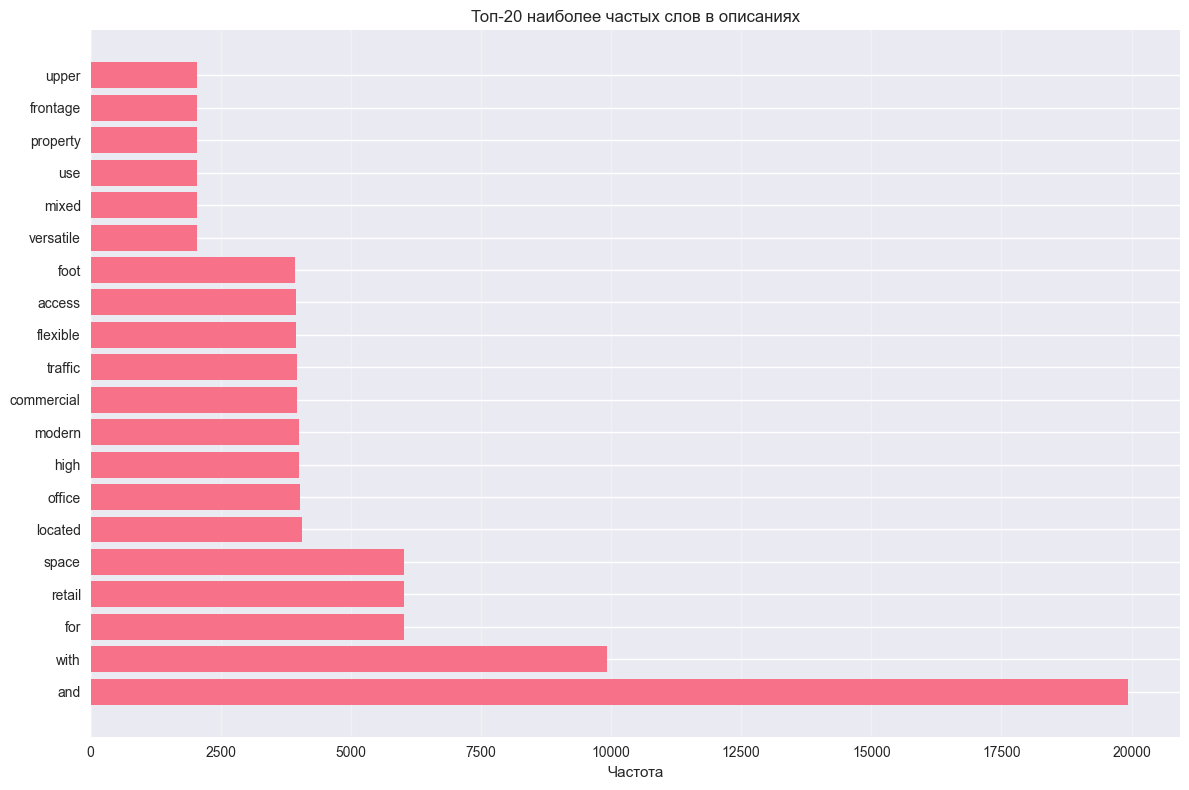


Всего уникальных слов: 91
Топ-10 слов:
  and: 19934
  with: 9914
  for: 6028
  retail: 6012
  space: 6012
  located: 4060
  office: 4026
  high: 4008
  modern: 4008
  commercial: 3973


In [22]:
# Анализ частотности слов в описаниях
if not df_cleaned.empty and 'description' in df_cleaned.columns:
    from collections import Counter
    import re

    # Объединение всех описаний
    all_descriptions = ' '.join(df_cleaned['description'].dropna().astype(str))

    # Извлечение слов (только буквы, минимум 3 символа)
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_descriptions.lower())

    # Подсчет частотности
    word_freq = Counter(words)
    top_words = word_freq.most_common(20)

    # Визуализация топ-слов
    words_list, counts_list = zip(*top_words)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(words_list)), counts_list)
    plt.yticks(range(len(words_list)), words_list)
    plt.xlabel('Частота')
    plt.title('Топ-20 наиболее частых слов в описаниях')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    print(f"\nВсего уникальных слов: {len(word_freq)}")
    print(f"Топ-10 слов:")
    for word, count in top_words[:10]:
        print(f"  {word}: {count}")


## 11. Сводные таблицы

### Выводы:

**По источникам данных:**
- **Crexi**: Средняя цена \$206.45 за кв.фут, медиана \$100.12 (4,985 записей)
- **LoopNet**: Средняя цена \$190.47 за кв.фут, медиана \$87.42 (4,988 записей)
- **Вывод**: Crexi показывает более высокие цены, но данные сопоставимы

**По городам (топ-5):**
1. **Chicago**: \$209.65 за кв.фут
2. **Phoenix**: \$201.60 за кв.фут
3. **Houston**: \$196.98 за кв.фут
4. **New York**: \$194.40 за кв.фут
5. **Los Angeles**: \$189.51 за кв.фут

**По штатам:**
1. **NY (New York)**: \$208.75 за кв.фут
2. **TX (Texas)**: \$203.17 за кв.фут
3. **IL (Illinois)**: \$198.88 за кв.фут
4. **CA (California)**: \$193.32 за кв.фут
5. **AZ (Arizona)**: \$188.36 за кв.фут

**По типам недвижимости:**
1. **Retail**: \$206.40 за кв.фут
2. **Mixed Use**: \$204.34 за кв.фут
3. **Warehouse**: \$196.82 за кв.фут
4. **Restaurant**: \$193.82 за кв.фут
5. **Office**: \$190.55 за кв.фут

**Вывод**: Географическое расположение и тип недвижимости существенно влияют на цену за кв.фут.


In [23]:
# Сводные таблицы
if not df_cleaned.empty:
    # Сводная таблица по источникам
    if 'source' in df_cleaned.columns and 'price_per_sqft' in df_cleaned.columns:
        pivot_source = df_cleaned.groupby('source')['price_per_sqft'].agg(['count', 'mean', 'median', 'std']).round(2)
        print("Сводная таблица по источникам данных:")
        display(pivot_source)

    # Сводная таблица по городам
    if 'city' in df_cleaned.columns and 'price_per_sqft' in df_cleaned.columns:
        pivot_city = df_cleaned.groupby('city')['price_per_sqft'].agg(['count', 'mean', 'median', 'std']).round(2)
        pivot_city = pivot_city.sort_values('mean', ascending=False).head(10)
        print("\nТоп-10 городов по средней цене за кв.фут:")
        display(pivot_city)

    # Сводная таблица по штатам
    if 'state' in df_cleaned.columns and 'price_per_sqft' in df_cleaned.columns:
        pivot_state = df_cleaned.groupby('state')['price_per_sqft'].agg(['count', 'mean', 'median', 'std']).round(2)
        pivot_state = pivot_state.sort_values('mean', ascending=False)
        print("\nСводная таблица по штатам:")
        display(pivot_state)


Сводная таблица по источникам данных:


,count,mean,median,std
source,,,,
Crexi,4983,193.45,98.94,318.53
LoopNet,4984,193.66,99.37,330.62



Топ-10 городов по средней цене за кв.фут:


,count,mean,median,std
city,,,,
Houston,2020,199.91,99.88,345.79
New York,1982,198.43,99.19,341.68
Chicago,2016,192.66,102.97,308.21
Phoenix,1959,189.71,96.08,324.92
Los Angeles,1990,186.96,98.16,300.08



Сводная таблица по штатам:


,count,mean,median,std
state,,,,
TX,2020,199.91,99.88,345.79
NY,1982,198.43,99.19,341.68
IL,2016,192.66,102.97,308.21
AZ,1959,189.71,96.08,324.92
CA,1990,186.96,98.16,300.08


## 12. Выводы и инсайты

- После очистки доступно 9 967 объектов и 60 признаков: демографические агрегаты Census добавлены, полностью пустые транспортные столбцы удалены.
- Целевая метрика остаётся скошенной (mean ≈ $193.6 vs median ≈ $99.2), но логарифм `price_per_sqft_log` снижает skew с 4.78 до ≈0 и нормализует хвосты.
- Стоимость за кв. фут растёт с общей ценой объекта (corr 0.33) и ощутимо снижается с увеличением площади (corr -0.53); остальные объектные признаки влияют слабее.
- Демография на уровне штата добавляет интерпретируемость: высокая занятость (corr ≈ 0.78) и низкая вакансия (corr ≈ -0.88) связаны с дорогими локациями; NY, CA и IL лидируют по доходам и цене.
- Сезонность выражена: декабрь 2024 — пик средних цен (~$215), июль 2025 — просадка (~$173); к осени уровень возвращается к ~$206.
- Текстовые описания (≈258 символов, 35 слов) подчёркивают преимущества локации, но их влияние на цену минимально — нужны дополнительные NLP-признаки.
- Следующие шаги: уточнять демографию на уровне города, учитывать сезонность и тестировать модели с лог-преобразованной целевой переменной.



### Ключевые выводы из проведенного EDA:

#### 1. Качество данных:
- **Общая разреженность**: 0% (после агрегирования по FIPS и удаления полностью пустых транспортных столбцов пропуски отсутствуют).
- **Выбросы**: 1 057 объектов (10.6%) с `price_per_sqft` выше IQR-порога — отражают премиальные площадки.
- **После очистки**: 9 967 строк и 60 признаков, включая 42 демографических показателя `census_*`.

#### 2. Распределение целевой переменной:
- **Средние показатели**: mean ≈ $193.6, median ≈ $99.2, min ≈ $1.41, max ≈ $3 905.74.
- **Лог-преобразование**: `skew` 4.78 → -0.07, `kurtosis` 30.19 → 0.49, QQ-plot близок к диагонали.
- **Рекомендация**: использовать `price_per_sqft_log` или робастные методы.

#### 3. Связи с целевой переменной:
- **Сильные драйверы**: `price` (corr 0.33) и `square_feet` (corr -0.53).
- **Категориальные факторы**: штаты и типы объектов дают до ~12% премии относительно медианы.
- **Демография**: высокая занятость (corr ≈ 0.78) и низкая вакансия (corr ≈ -0.88) по штатам ассоциированы с дорогими рынками; доход и доля выпускников дают умеренную премию.

#### 4. География и типы недвижимости:
- **Штаты (медиана $/кв.фут)**: IL 103, TX 100, NY 99, CA 98, AZ 96; NY/CA обеспечивают самые высокие средние (> $200).
- **Типы (топ-5 медиан)**: Retail 101.9, Mixed Use 99.9, Office 98.6, Warehouse 98.5, Restaurant 98.0.
- **Подгруппы**: violin-плоты показывают многомодальность в премиальных сегментах (NY, Retail).

#### 5. Временная динамика:
- **Горизонт**: ноябрь 2024 – ноябрь 2025, ежемесячно 500–900 объектов.
- **Пики/просадки**: декабрь 2024 и ноябрь 2025 — рост средних (~$221), март–июль 2025 — локальный спад (mean 177–180, median ≈ $100).
- **Осеннее восстановление**: сентябрь–октябрь 2025 возвращаются к ~$205 при медиане 98–102.

#### 6. Текстовые данные:
- **Структура**: средняя длина описаний 258 символов (35 слов), 55 ключевых терминов.
- **Частотность**: доминируют commercial, retail, office, property, visibility.
- **Вывод**: без продвинутых NLP-признаков вклад текстов ограничен.

#### 7. Рекомендации:
- Использовать лог-преобразованную целевую переменную и демографические агрегаты в моделировании.
- При расширении датасета уточнять демографию до уровня города и добавлять реальные транспортные метрики.
- Учесть сезонность (зимние пики и летние просадки) в прогнозах и бизнес-планах.



In [24]:
# Сохранение очищенного датасета
if not df_cleaned.empty:
    output_path = Path('../data/processed/cleaned_dataset.csv')
    df_cleaned.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Очищенный датасет сохранен в {output_path}")
    print(f"Финальный размер датасета: {df_cleaned.shape}")


Очищенный датасет сохранен в ../data/processed/cleaned_dataset.csv
Финальный размер датасета: (9967, 60)
